## Description:

Conducts DMD analysis on time series data. Plots the eigenmodes, eigenvalues anda attempts to preduct next time step using the learned modes.

In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("..")
import yaml

from flamekit.io_fields import field_path
from flamekit.io_fronts import Case
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD
from mpi4py import MPI


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "configs" / "DMD.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

# Input Parameters (from YAML)
# ============================================================
TIME_STEP_START = int(CFG["TIME_STEP_START"])
TIME_STEP_END = int(CFG["TIME_STEP_END"])

PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
POST = bool(CFG["POST"])

BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])  # where extracted_field[_post]_{t}.csv were saved

VAR_NAME = str(CFG["VAR_NAME"])  # field to run DMD on
SORT_COLS = list(CFG["SORT_COLS"])  # stable ordering key for the state vector
COORD_TOL = float(CFG["COORD_TOL"])  # set to >0 (e.g. 1e-12) if you want tolerance checks

# Cropping: keep only points with x > X_THESHOLD
X_THESHOLD = float(CFG["X_THESHOLD"])

OUT_DIR = PROJECT_ROOT / Path(CFG["OUT_DIR"])

# Optional: limit number of modes via truncated SVD (null = no limit)
DMD_SVD_RANK = CFG.get("DMD_SVD_RANK", None)


# Helpers: locate + read the FULL FIELD CSV (NO iso)
# ============================================================

def field_csv_path(base_dir: Path, phi: float, lat_size: str, time_step: int, post: bool) -> Path:
    case = Case(
        base_dir=base_dir,
        phi=phi,
        lat_size=lat_size,
        time_step=time_step,
        post=post,
    )
    return field_path(case)

def read_field_sorted(path: Path, var_name: str, sort_cols: list[str]) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      coords: (n_points, len(sort_cols)) array of coordinates (sorted)
      values: (n_points,) array of var_name values (sorted same way)
    """
    if not path.exists():
        raise FileNotFoundError(f"Missing file:\n  {path}")

    df = pd.read_csv(path)

    missing = [c for c in (sort_cols + [var_name]) if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name}: missing columns {missing}")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=sort_cols + [var_name])
    df = df.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)

    coords = df[sort_cols].to_numpy(dtype=np.float64)
    values = df[var_name].to_numpy(dtype=np.float64)
    return coords, values




In [3]:


# Build snapshot matrix X for DMD (NO interpolation)
# ============================================================

comm = MPI.COMM_WORLD
rank = comm.rank

times = list(range(TIME_STEP_START, TIME_STEP_END + 1))

# Read reference timestep (FULL, then build mask from it)
ref_path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, times[0], POST)
coords_ref_full, snap0_full = read_field_sorted(ref_path, VAR_NAME, SORT_COLS)

# Apply x-threshold mask ONCE, then apply same mask to all timesteps
x_ref = coords_ref_full[:, 0]
mask_x = x_ref > X_THESHOLD

coords_ref = coords_ref_full[mask_x]
snap0 = snap0_full[mask_x]

n_points = coords_ref.shape[0]
n_snapshots = len(times)

if rank == 0:
    print(f"Reference timestep: {times[0]}")
    print(f"X_THESHOLD={X_THESHOLD} -> keeping {n_points}/{coords_ref_full.shape[0]} points")
    print(f"n_points={n_points}, n_snapshots={n_snapshots}")
    print(f"Reading: {ref_path}")

snapshots = [snap0]

# Read remaining timesteps, verify identical FULL coordinates, then apply same mask
for t in times[1:]:
    path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, t, POST)
    coords_t_full, snap_t_full = read_field_sorted(path, VAR_NAME, SORT_COLS)

    if coords_t_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"Inconsistent number of points (full) at timestep {t}: {coords_t_full.shape[0]} vs {coords_ref_full.shape[0]}.\n"
            f"Interpolation (or re-meshing to a common grid) would be required."
        )

    # Coordinate consistency check on FULL coords
    if COORD_TOL == 0.0:
        same = np.array_equal(coords_t_full, coords_ref_full)
    else:
        same = np.allclose(coords_t_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            f"Coordinates do not match reference at timestep {t}.\n"
            f"Set COORD_TOL>0 to allow tolerance, or use interpolation onto a common grid."
        )

    # Apply same mask
    snap_t = snap_t_full[mask_x]
    snapshots.append(snap_t)

# Snapshot matrix: shape (n_state, n_snapshots)
X = np.stack(snapshots, axis=1)
if rank == 0:
    print("X shape:", X.shape)

# DMD
# ============================================================

if DMD_SVD_RANK is None:
    dmd = DMD()
else:
    dmd = DMD(svd_rank=int(DMD_SVD_RANK))
dmd.fit(X)



Reference timestep: 200
X_THESHOLD=300.0 -> keeping 255744/839680 points
n_points=255744, n_snapshots=101
Reading: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/isocontours/phi0.40/h400x025_ref/extracted_field_post_200.csv
X shape: (255744, 101)


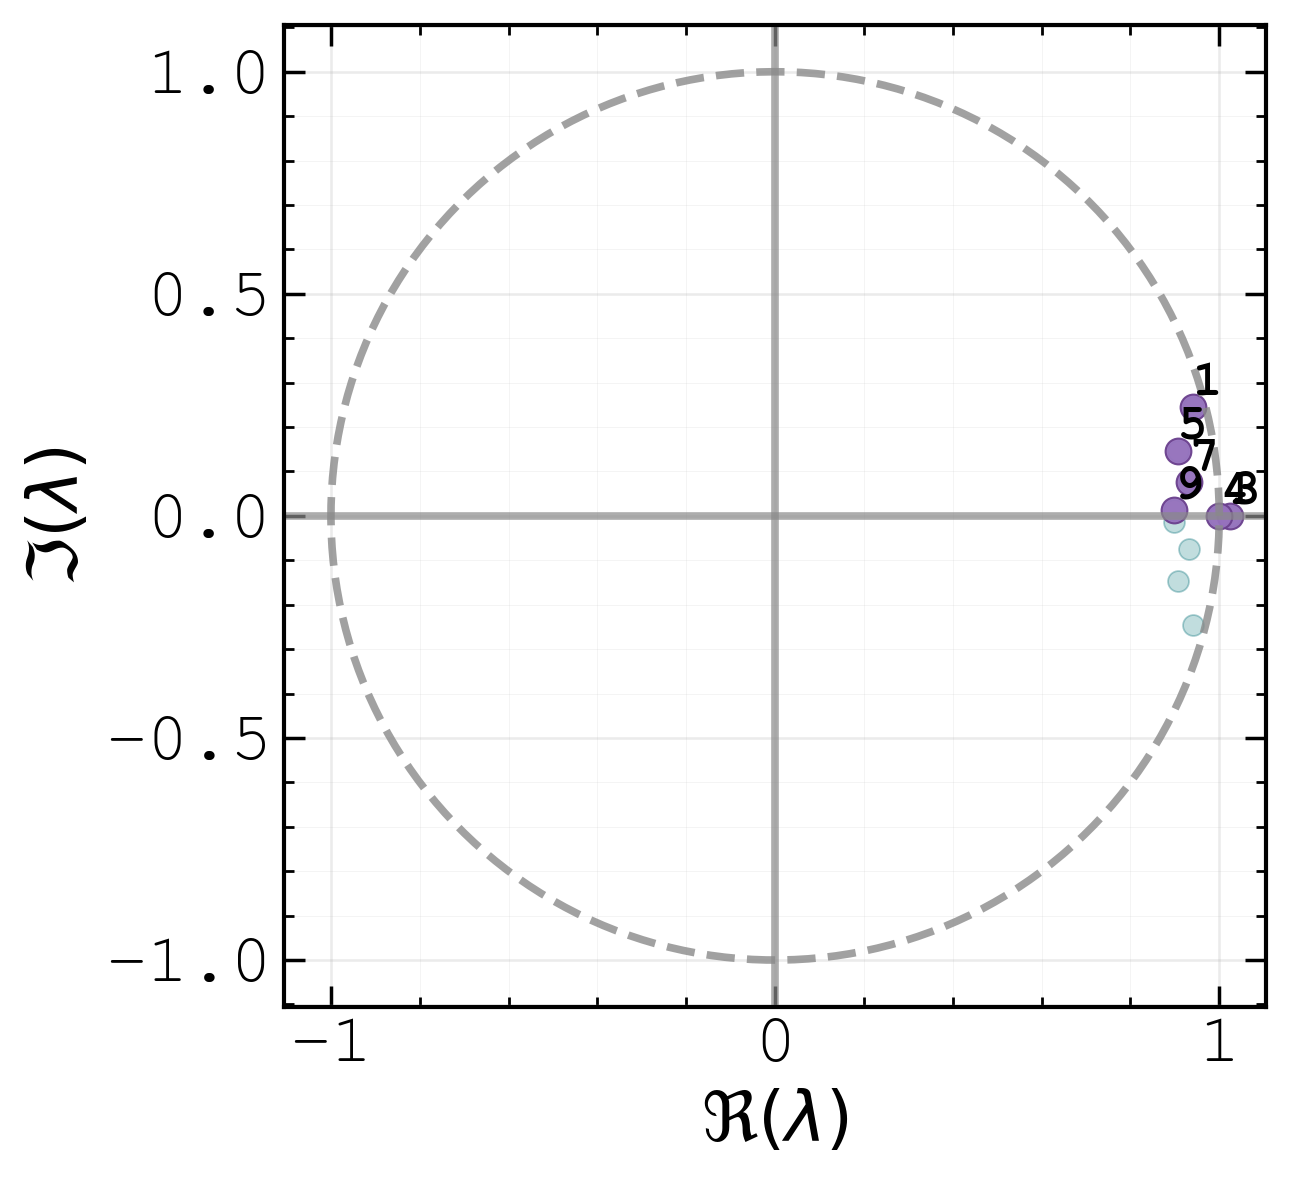

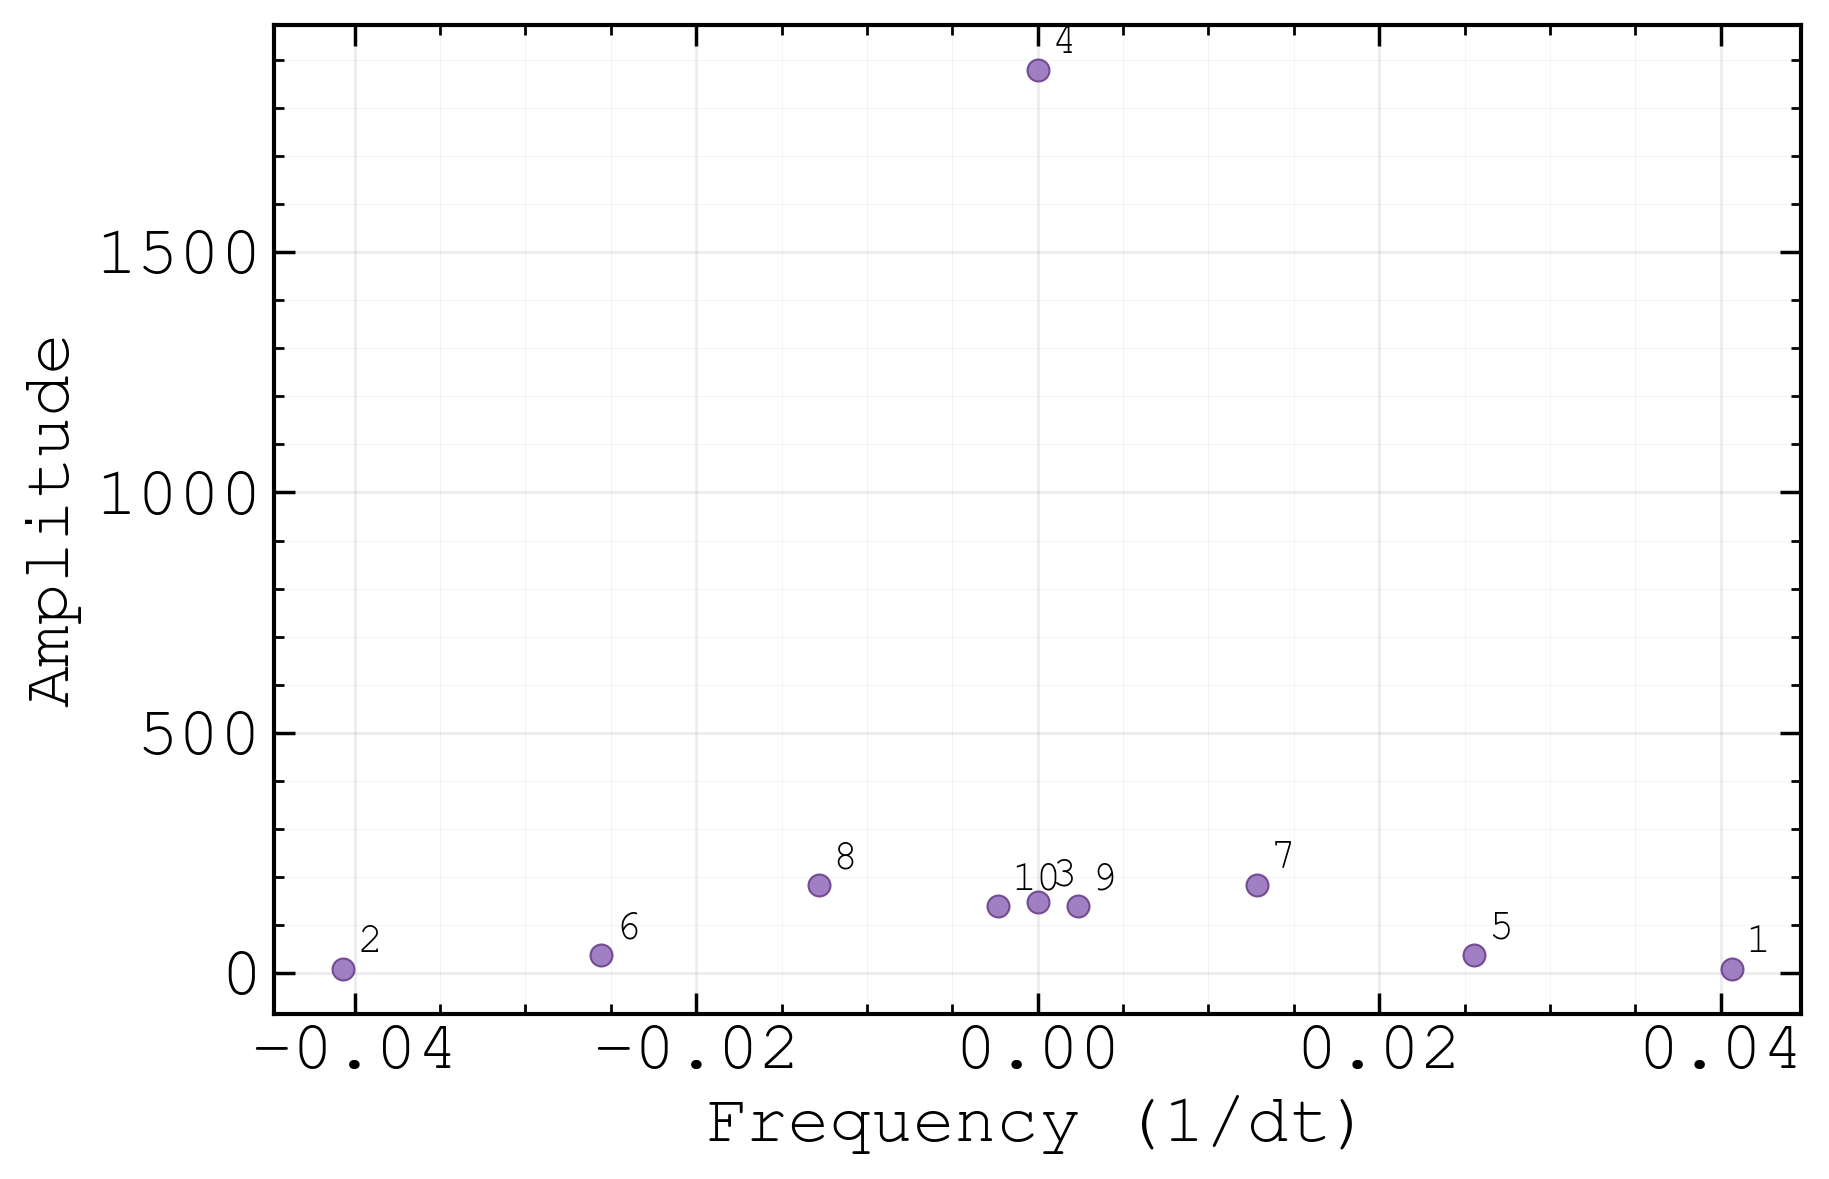

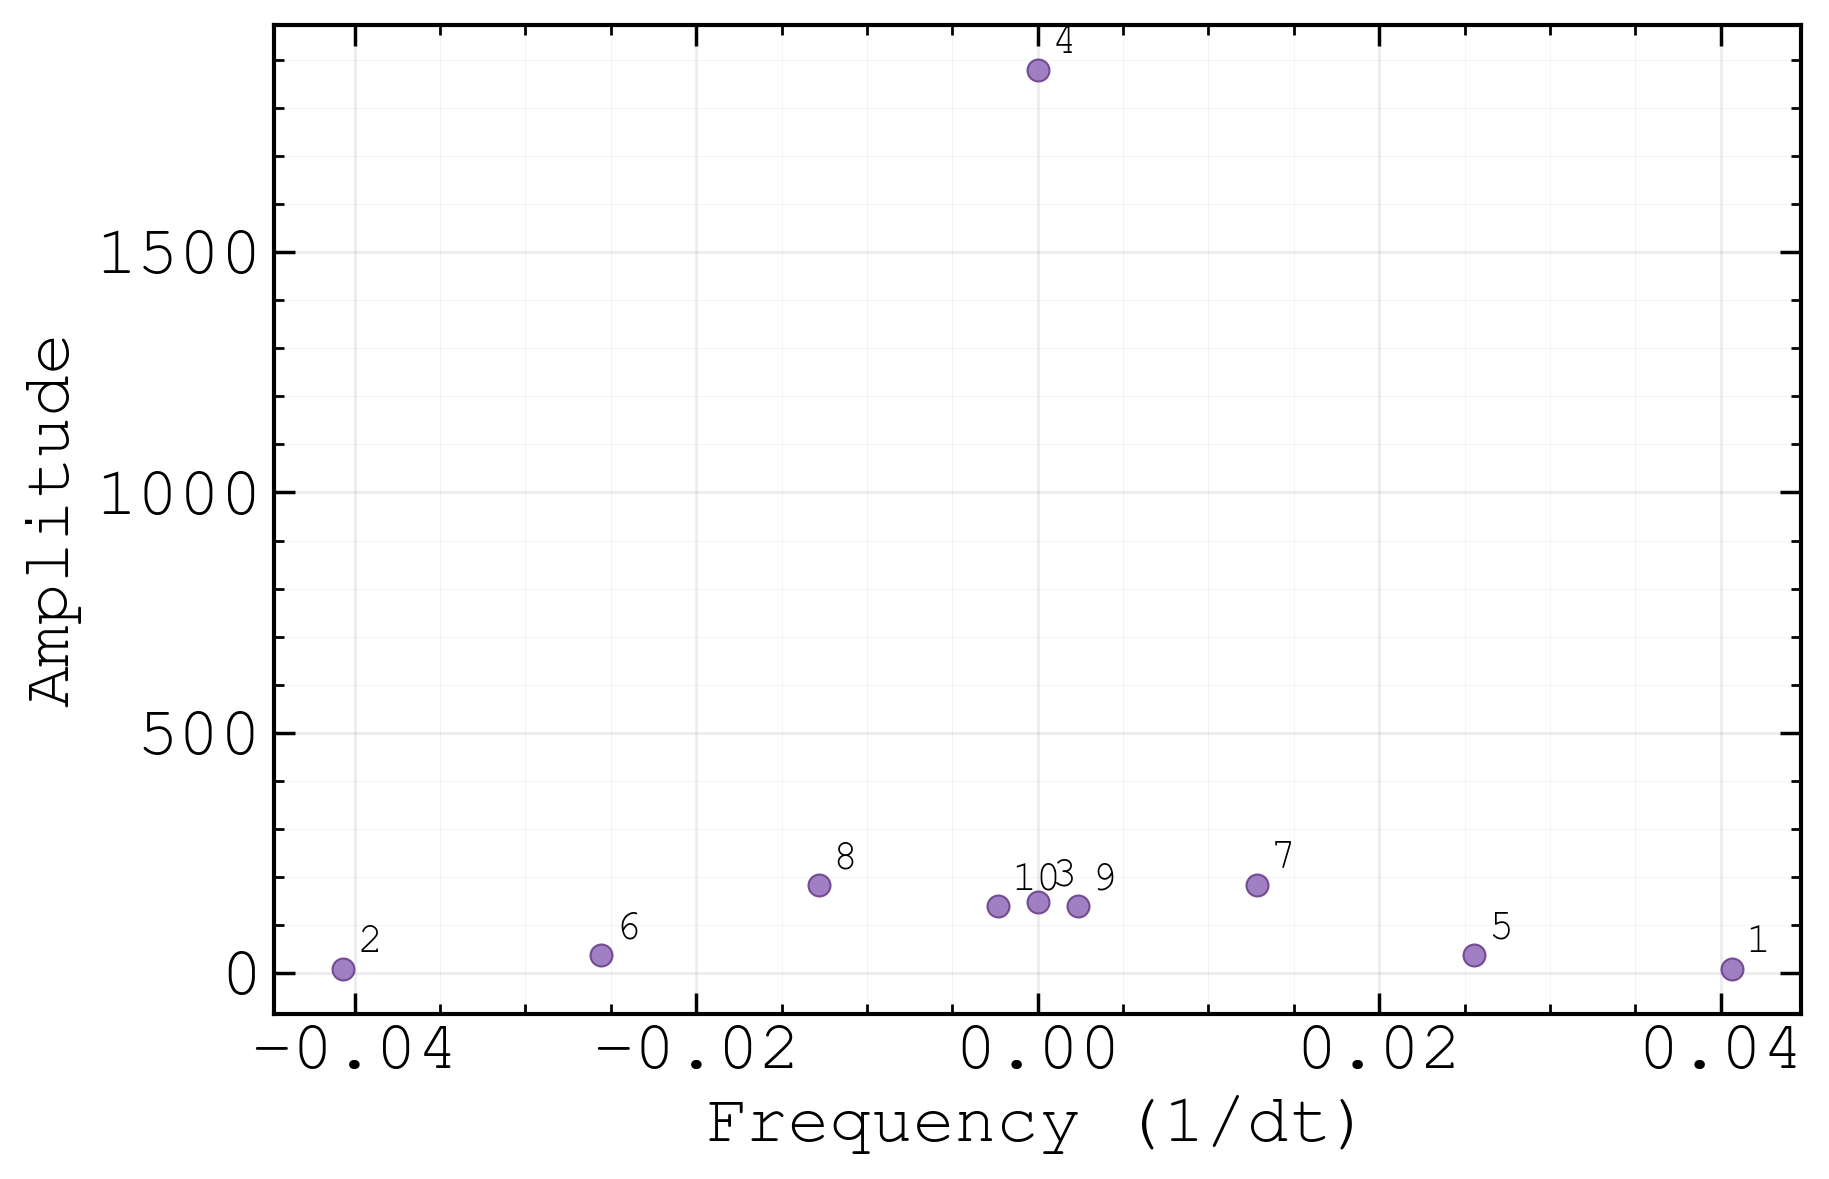

In [21]:

# Output directory 
OUT_DIR = PROJECT_ROOT / Path(CFG["OUT_DIR"])
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# PLOT STYLE (template-based)
# ============================================================
PLOT_FONT_FAMILY = "Courier New"
PLOT_FONT_SIZE = 20
FIG_DPI = 250
LINE_WIDTH = 2.2

COLOR_DATA = "#77b5b6"
COLOR_DATA_EDGE = "#378d94"
COLOR_PRED = "#9671bd"
COLOR_PRED_EDGE = "#6a408d"
COLOR_NEUTRAL = "#7e7e7e"
COLOR_LINE = "#8a8a8a"

def apply_plot_style() -> None:
    plt.rcParams.update({
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
    })

apply_plot_style()

def style_colorbar(cbar, *, nbins: int = 5) -> None:
    from matplotlib.ticker import MaxNLocator
    cbar.ax.tick_params(labelsize=PLOT_FONT_SIZE - 6)
    cbar.locator = MaxNLocator(nbins=nbins)
    cbar.update_ticks()

def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        style_axes(ax)
def annotate_no_overlap(
    ax,
    xs,
    ys,
    labels,
    *,
    min_sep=0.025,
    fontsize=None,
    fontweight=None,
) -> None:
    xs = np.asarray(xs, dtype=float)
    ys = np.asarray(ys, dtype=float)

    if xs.size == 0:
        return

    x_span = float(np.ptp(xs)) or 1.0
    y_span = float(np.ptp(ys)) or 1.0

    offsets = [
        (0.01, 0.01),
        (0.01, -0.01),
        (-0.01, 0.01),
        (-0.01, -0.01),
        (0.02, 0.0),
        (-0.02, 0.0),
        (0.0, 0.02),
        (0.0, -0.02),
        (0.03, 0.03),
        (0.03, -0.03),
        (-0.03, 0.03),
        (-0.03, -0.03),
    ]

    placed = []
    for x, y, label in zip(xs, ys, labels):
        best = None
        for ox, oy in offsets:
            tx = x + ox * x_span
            ty = y + oy * y_span
            if all((abs(tx - px) > min_sep * x_span) or (abs(ty - py) > min_sep * y_span) for px, py in placed):
                best = (tx, ty)
                break
        if best is None:
            best = (x + 0.04 * x_span, y + 0.04 * y_span)
        ax.text(
            best[0],
            best[1],
            str(label),
            fontsize=fontsize or (PLOT_FONT_SIZE - 8),
            fontweight=fontweight,
            ha="left",
            va="bottom",
        )
        placed.append(best)



def plot_dmd_eigs_report(
    dmd,
    VAR_NAME="field",
    OUT_DIR=None,          # pathlib.Path or None
    stem="dmd_eigs_complex_plane",
    label_top_n=12,        # label only the most "important" modes to avoid clutter
    MODE_IMAG_TOL=1e-10,
    use_amp_rms_for_labels=True,
):
    lam = np.asarray(dmd.eigs, dtype=complex)

    # Optional importance metric for labeling
    if use_amp_rms_for_labels and hasattr(dmd, "dynamics"):
        dyn = np.asarray(dmd.dynamics)
        amp_rms = np.sqrt(np.mean(np.abs(dyn) ** 2, axis=1))
    else:
        amp_rms = np.ones(len(lam))

    # Keep one per conjugate pair: real + upper half-plane
    indices_keep = []
    for i, li in enumerate(lam):
        if li.imag > MODE_IMAG_TOL:
            indices_keep.append(i)
        elif abs(li.imag) <= MODE_IMAG_TOL:
            indices_keep.append(i)
    indices_keep = np.array(indices_keep, dtype=int)

    # Choose which indices to annotate (top-N by amp_rms among kept)
    order = indices_keep[np.argsort(amp_rms[indices_keep])[::-1]]
    idx_annot = order[:min(label_top_n, len(order))]

    fig = plt.figure(figsize=(7.2, 4.6), dpi=FIG_DPI, constrained_layout=True)
    ax = fig.add_subplot(111)

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), linestyle="--", linewidth=LINE_WIDTH, color=COLOR_LINE, alpha=0.8)

    # Axes lines
    ax.axhline(0.0, linewidth=LINE_WIDTH, color=COLOR_LINE, alpha=0.7)
    ax.axvline(0.0, linewidth=LINE_WIDTH, color=COLOR_LINE, alpha=0.7)

    # Plot all eigenvalues (light)
    ax.scatter(lam.real, lam.imag, s=36, alpha=0.45, color=COLOR_DATA, edgecolors=COLOR_DATA_EDGE, linewidths=0.5)

    # Highlight kept (one per conj. pair)
    ax.scatter(lam[indices_keep].real, lam[indices_keep].imag, s=55, alpha=0.95, color=COLOR_PRED, edgecolors=COLOR_PRED_EDGE, linewidths=0.6)

    # Annotate selected modes only (avoid clutter)
    xs = lam[idx_annot].real
    ys = lam[idx_annot].imag
    labels = [k + 1 for k in idx_annot]
    annotate_no_overlap(ax, xs, ys, labels, min_sep=0.03, fontsize=PLOT_FONT_SIZE - 6, fontweight="bold")

    ax.set_xlabel(r"$\Re(\lambda)$")
    ax.set_ylabel(r"$\Im(\lambda)$")
    style_axes(ax)

    # Limits: slightly padded around points + unit circle
    rmax = max(1.0, np.max(np.abs(lam)) if len(lam) else 1.0)
    lim = 1.08 * rmax
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect("equal", adjustable="box")
    style_axes(ax)


    # Save if requested
    if OUT_DIR is not None:
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        fig.savefig(OUT_DIR / f"{stem}.png", dpi=FIG_DPI)
        fig.savefig(OUT_DIR / f"{stem}.pdf")
        fig.savefig(OUT_DIR / f"{stem}.svg")

    plt.show()
def plot_dmd_amp_vs_freq(
    dmd,
    *,
    OUT_DIR=None,
    stem="dmd_amp_vs_freq",
    dt=None,
):
    lam = np.asarray(dmd.eigs, dtype=complex)

    if dt is None:
        if hasattr(dmd, "dmd_time") and "dt" in dmd.dmd_time:
            dt = float(dmd.dmd_time["dt"])
        else:
            dt = 1.0

    if hasattr(dmd, "amplitudes") and dmd.amplitudes is not None:
        amps = np.abs(np.asarray(dmd.amplitudes))
    elif hasattr(dmd, "dynamics"):
        dyn = np.asarray(dmd.dynamics)
        amps = np.sqrt(np.mean(np.abs(dyn) ** 2, axis=1))
    else:
        amps = np.ones(len(lam))

    omega = np.log(lam) / dt
    freq = omega.imag / (2 * np.pi)

    valid = np.isfinite(freq) & np.isfinite(amps)
    valid_idx = np.nonzero(valid)[0]
    freq = freq[valid]
    amps = amps[valid]

    fig = plt.figure(figsize=(7.2, 4.6), dpi=FIG_DPI, constrained_layout=True)
    ax = fig.add_subplot(111)
    ax.scatter(freq, amps, s=40, alpha=0.9, color=COLOR_PRED, edgecolors=COLOR_PRED_EDGE, linewidths=0.6)

    labels = [idx + 1 for idx in valid_idx]
    annotate_no_overlap(ax, freq, amps, labels, min_sep=0.025, fontsize=PLOT_FONT_SIZE - 8)
    ax.set_xlabel("Frequency (1/dt)" if CFG.get("DT", None) is None else "Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    style_axes(ax)

    if OUT_DIR is not None:
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        fig.savefig(OUT_DIR / f"{stem}.png", dpi=FIG_DPI)
        fig.savefig(OUT_DIR / f"{stem}.pdf")
        fig.savefig(OUT_DIR / f"{stem}.svg")

    plt.show()
    return fig

def plot_dmd_amp_vs_freq(
    dmd,
    *,
    OUT_DIR=None,
    stem="dmd_amp_vs_freq",
    dt=None,
):
    lam = np.asarray(dmd.eigs, dtype=complex)

    if dt is None:
        if hasattr(dmd, "dmd_time") and "dt" in dmd.dmd_time:
            dt = float(dmd.dmd_time["dt"])
        else:
            dt = 1.0

    if hasattr(dmd, "amplitudes") and dmd.amplitudes is not None:
        amps = np.abs(np.asarray(dmd.amplitudes))
    elif hasattr(dmd, "dynamics"):
        dyn = np.asarray(dmd.dynamics)
        amps = np.sqrt(np.mean(np.abs(dyn) ** 2, axis=1))
    else:
        amps = np.ones(len(lam))

    omega = np.log(lam) / dt
    freq = omega.imag / (2 * np.pi)

    valid = np.isfinite(freq) & np.isfinite(amps)
    valid_idx = np.nonzero(valid)[0]
    freq = freq[valid]
    amps = amps[valid]

    fig = plt.figure(figsize=(7.2, 4.6), dpi=FIG_DPI, constrained_layout=True)
    ax = fig.add_subplot(111)
    ax.scatter(freq, amps, s=40, alpha=0.9, color=COLOR_PRED, edgecolors=COLOR_PRED_EDGE, linewidths=0.6)

    labels = [idx + 1 for idx in valid_idx]
    annotate_no_overlap(ax, freq, amps, labels, min_sep=0.025, fontsize=PLOT_FONT_SIZE - 8)
    ax.set_xlabel("Frequency (1/dt)" if CFG.get("DT", None) is None else "Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    style_axes(ax)

    if OUT_DIR is not None:
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        fig.savefig(OUT_DIR / f"{stem}.png", dpi=FIG_DPI)
        fig.savefig(OUT_DIR / f"{stem}.pdf")
        fig.savefig(OUT_DIR / f"{stem}.svg")

    plt.show()
    return fig

# --- usage (consistent with your previous saving approach) ---
plot_dmd_eigs_report(
    dmd,
    VAR_NAME=VAR_NAME,
    OUT_DIR=OUT_DIR,  # same Path you used before
    stem=f"dmd_eigs_{VAR_NAME}",
    label_top_n=12
)

plot_dmd_amp_vs_freq(
    dmd,
    OUT_DIR=OUT_DIR,
    stem="dmd_amp_vs_freq",
    dt=CFG.get("DT", None),
)













In [22]:
print("DMD eigenvalues:", dmd.eigs)
print("modes shape:", dmd.modes.shape)
print("dynamics shape:", dmd.dynamics.shape)


DMD eigenvalues: [0.94040749+0.24557463j 0.94040749-0.24557463j 1.02367749+0.j
 1.0002183 +0.j         0.9060673 +0.14680493j 0.9060673 -0.14680493j
 0.93122975+0.07519718j 0.93122975-0.07519718j 0.89862266+0.01325483j
 0.89862266-0.01325483j]
modes shape: (255744, 10)
dynamics shape: (10, 102)


In [23]:
DT = CFG["DT"]

MODE_IMAG_TOL = float(CFG["MODE_IMAG_TOL"])
FREQ_TOL = float(CFG["FREQ_TOL"])

N_MODES_TO_PLOT = int(CFG["N_MODES_TO_PLOT"])
NORMALIZE_MODE_FOR_PLOT = bool(CFG["NORMALIZE_MODE_FOR_PLOT"])

CONTOUR_LEVELS_FILLED = int(CFG["CONTOUR_LEVELS_FILLED"])
CONTOUR_LEVELS_LINES = int(CFG["CONTOUR_LEVELS_LINES"])
MODE_CONTOUR_LEVELS_FILLED = int(CFG.get("MODE_CONTOUR_LEVELS_FILLED", min(CONTOUR_LEVELS_FILLED, 20)))

COORD_X = str(CFG["COORD_X"])
COORD_Y = str(CFG["COORD_Y"])

XLIM = CFG["XLIM"]
YLIM = CFG["YLIM"]
# -------------------------



### Predict next time step

Unstable modes (|λ|>1): 2
Max |λ|: 1.0236774903394639
Wrote: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/isocontours/phi0.40/h400x025_ref/dmd_pred_T_301_xgt300.csv


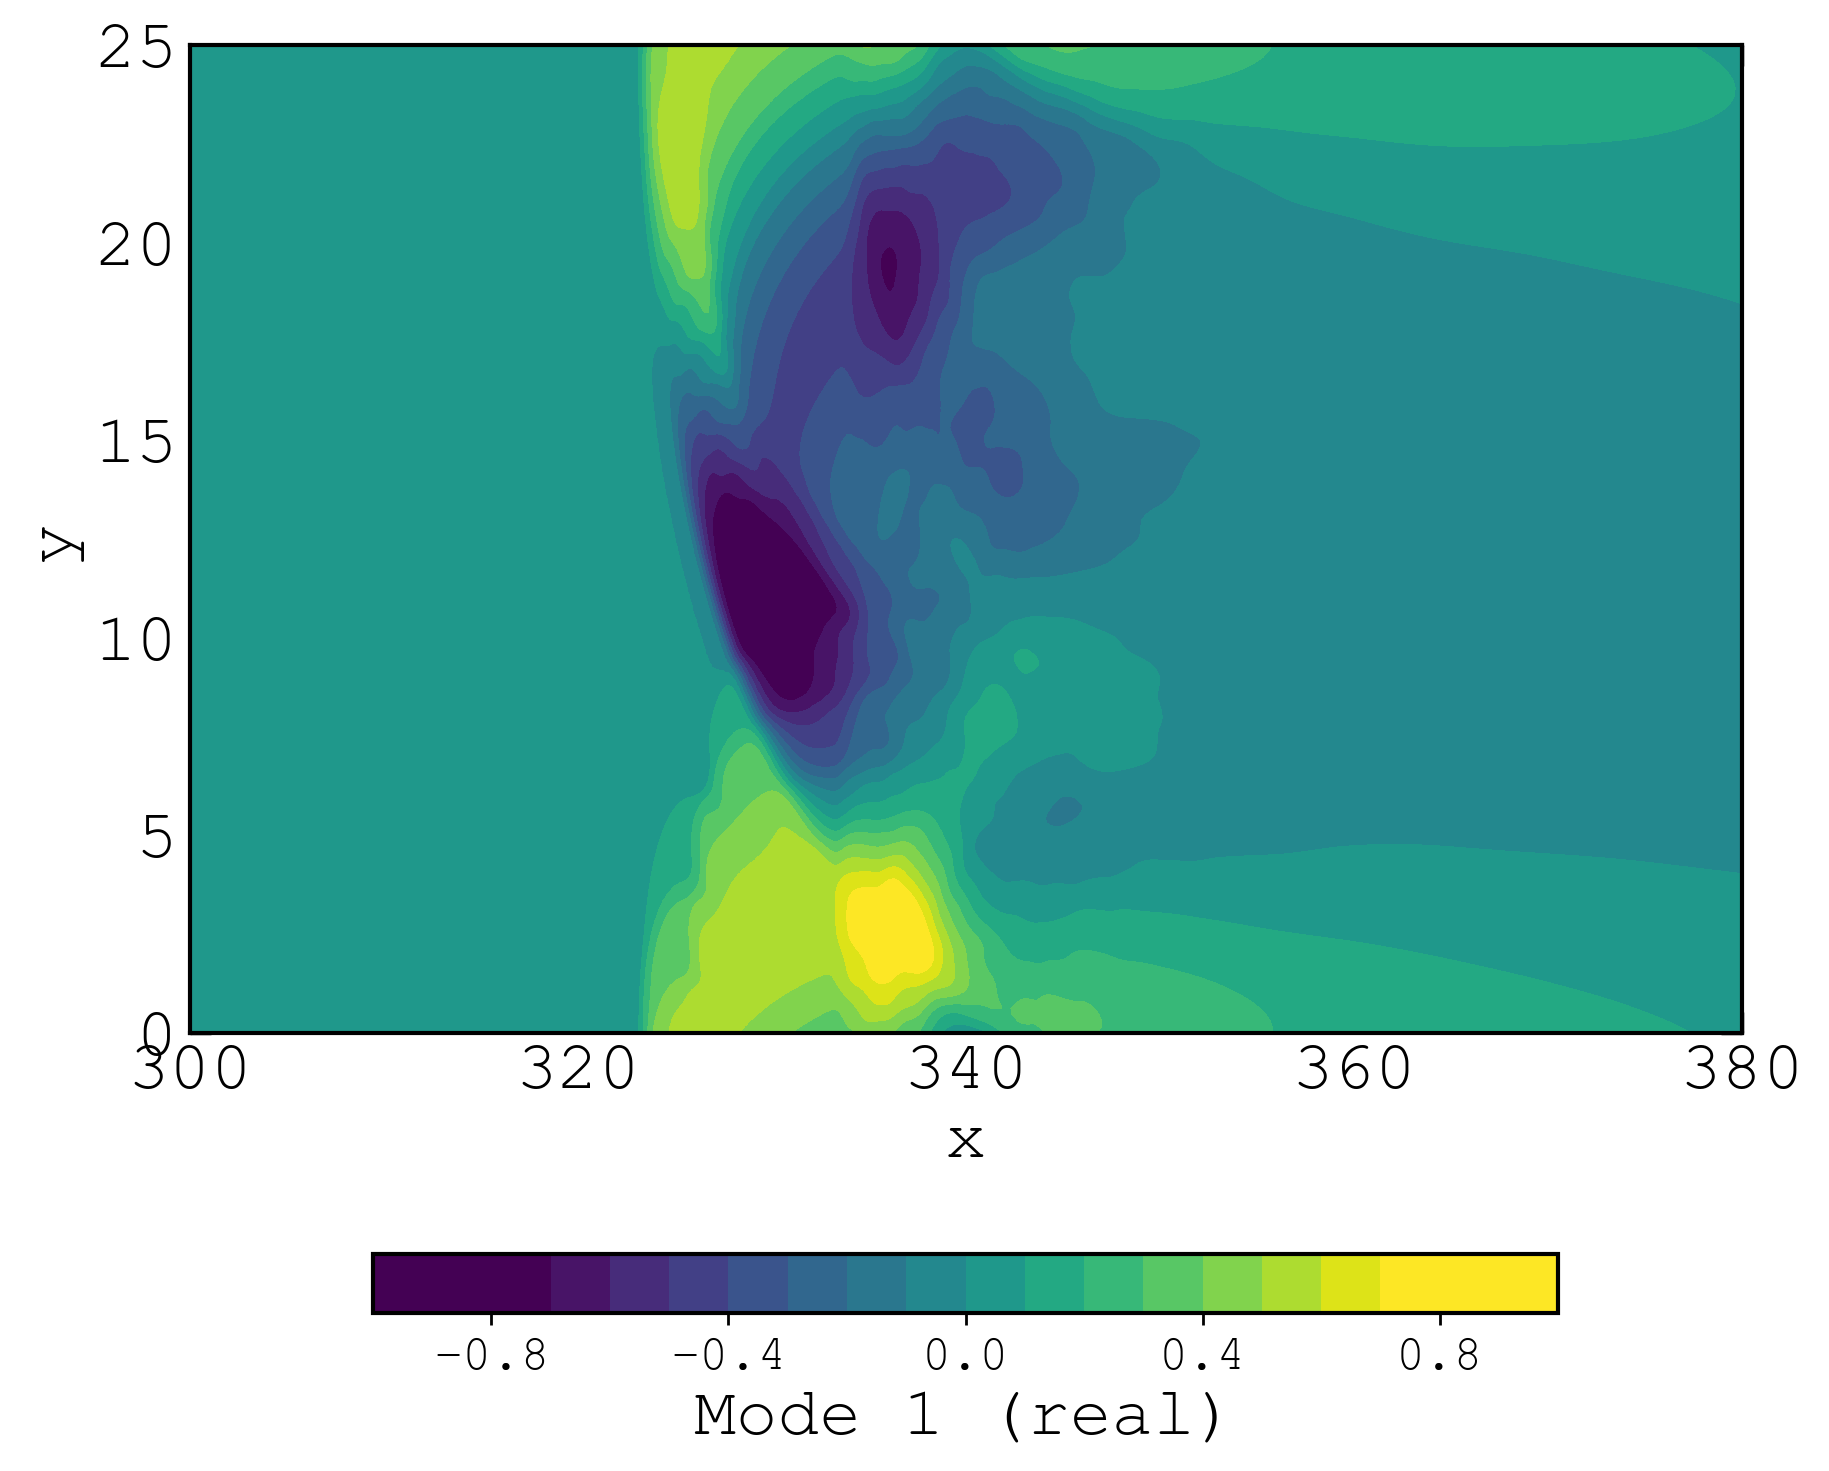

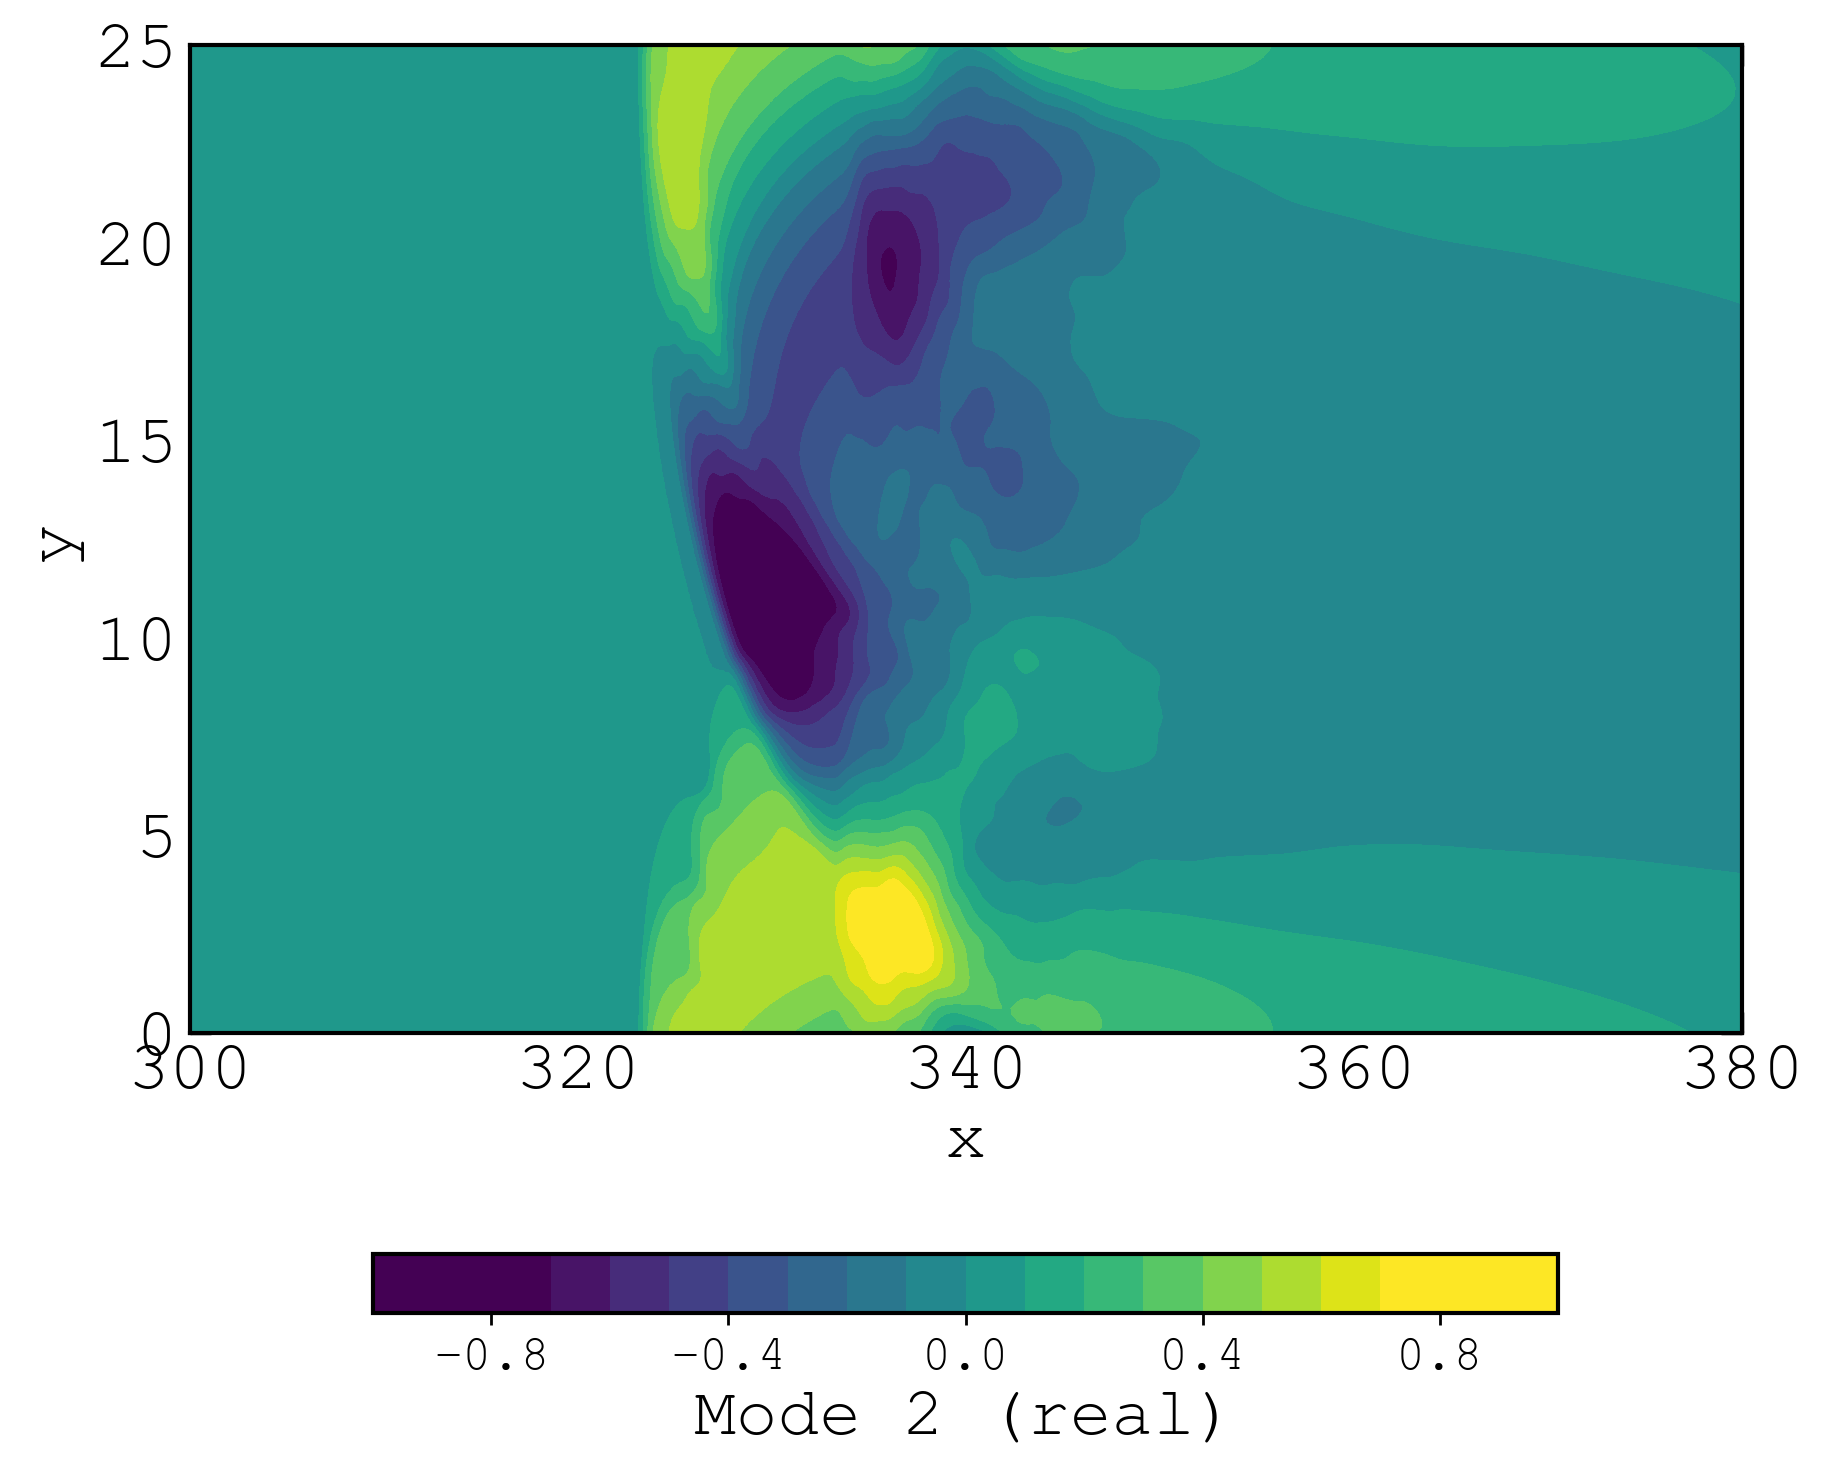

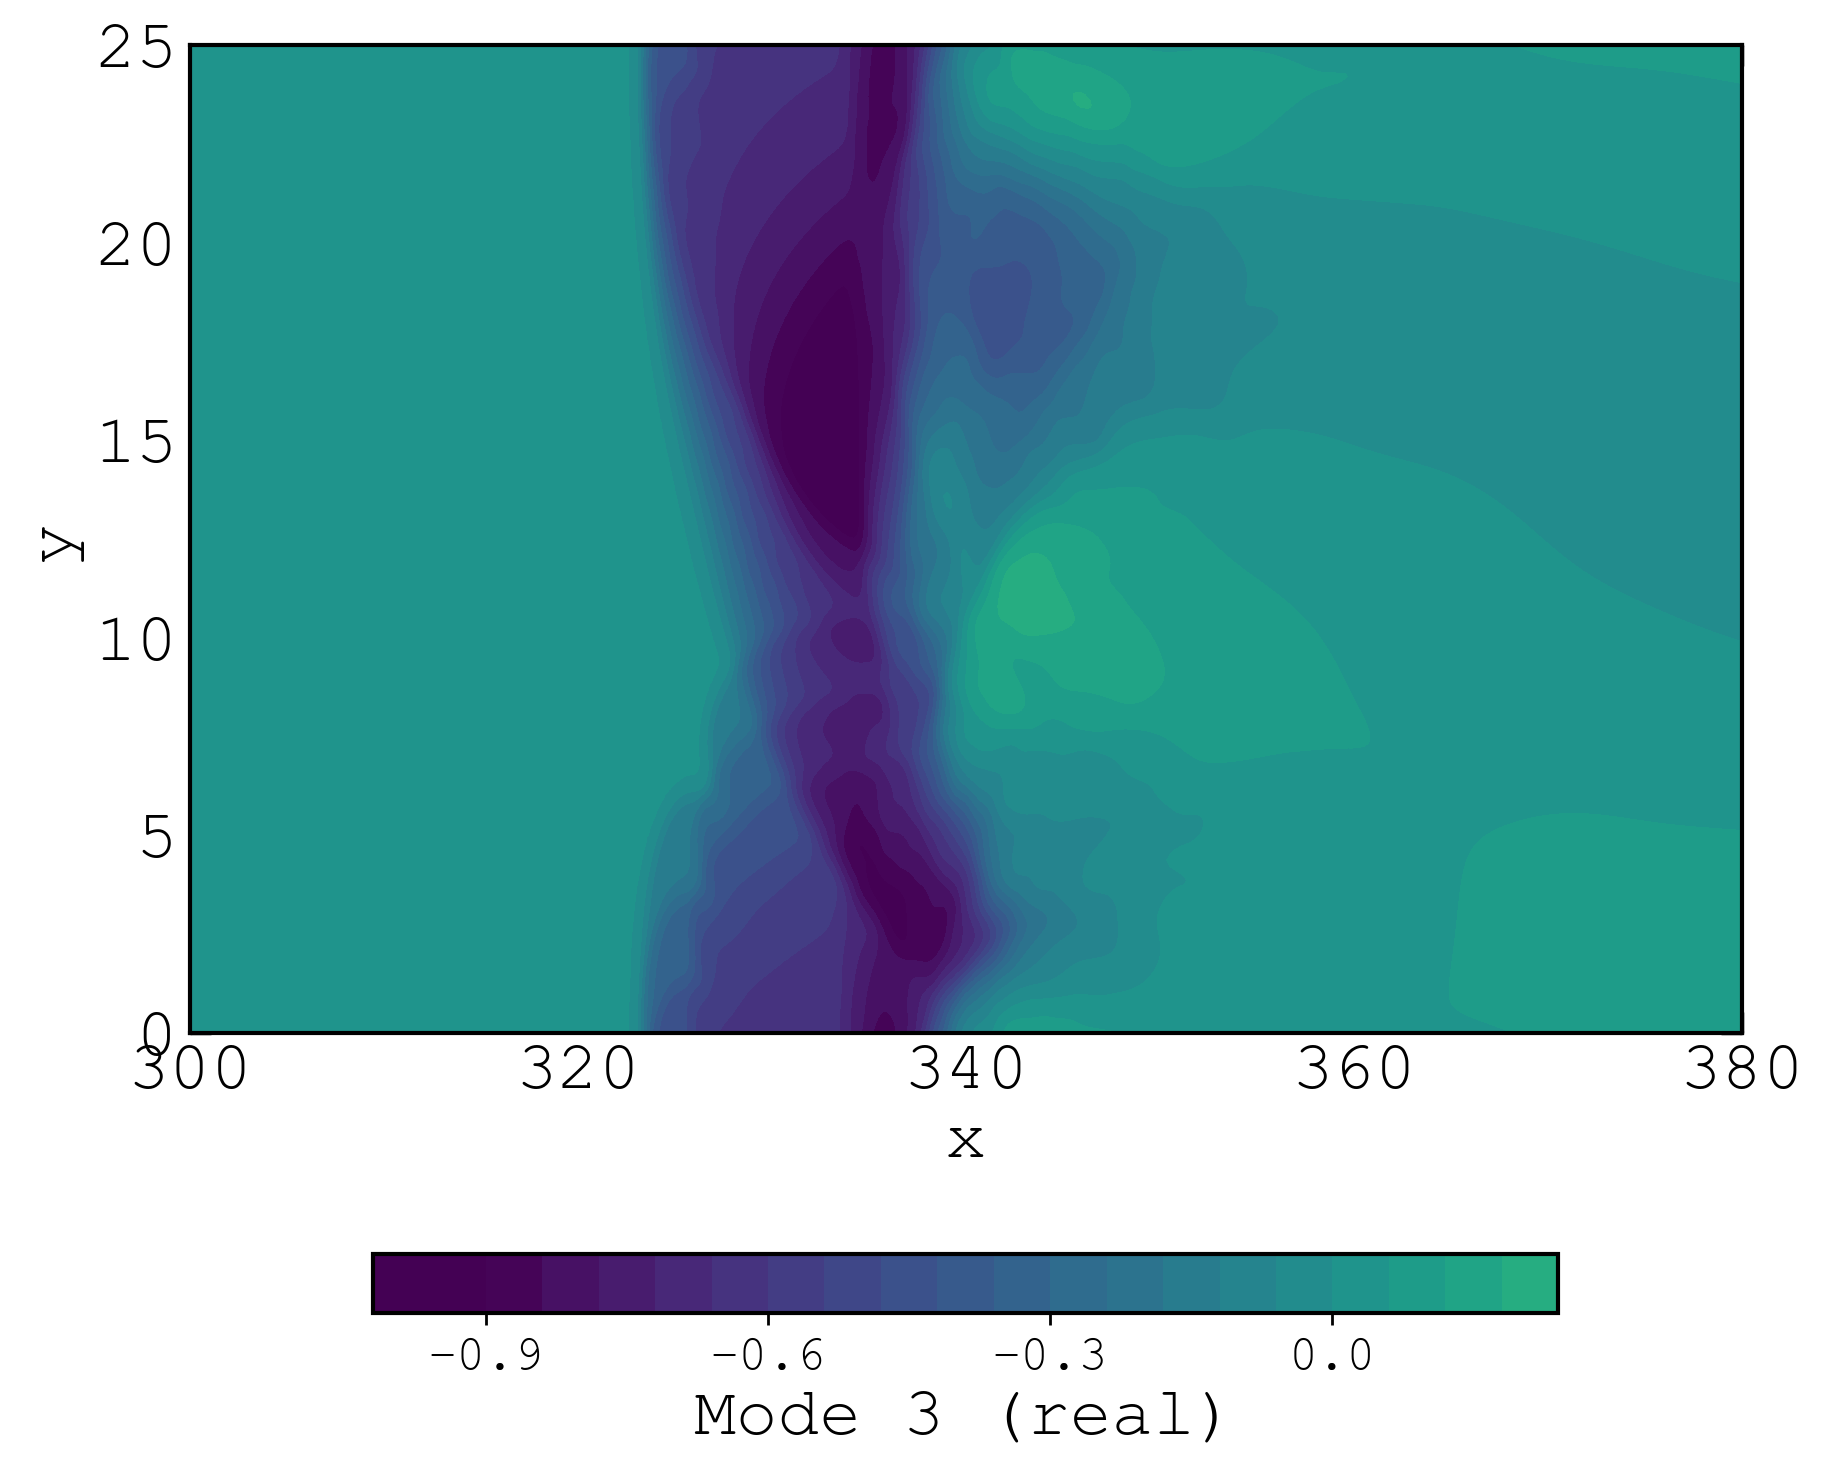

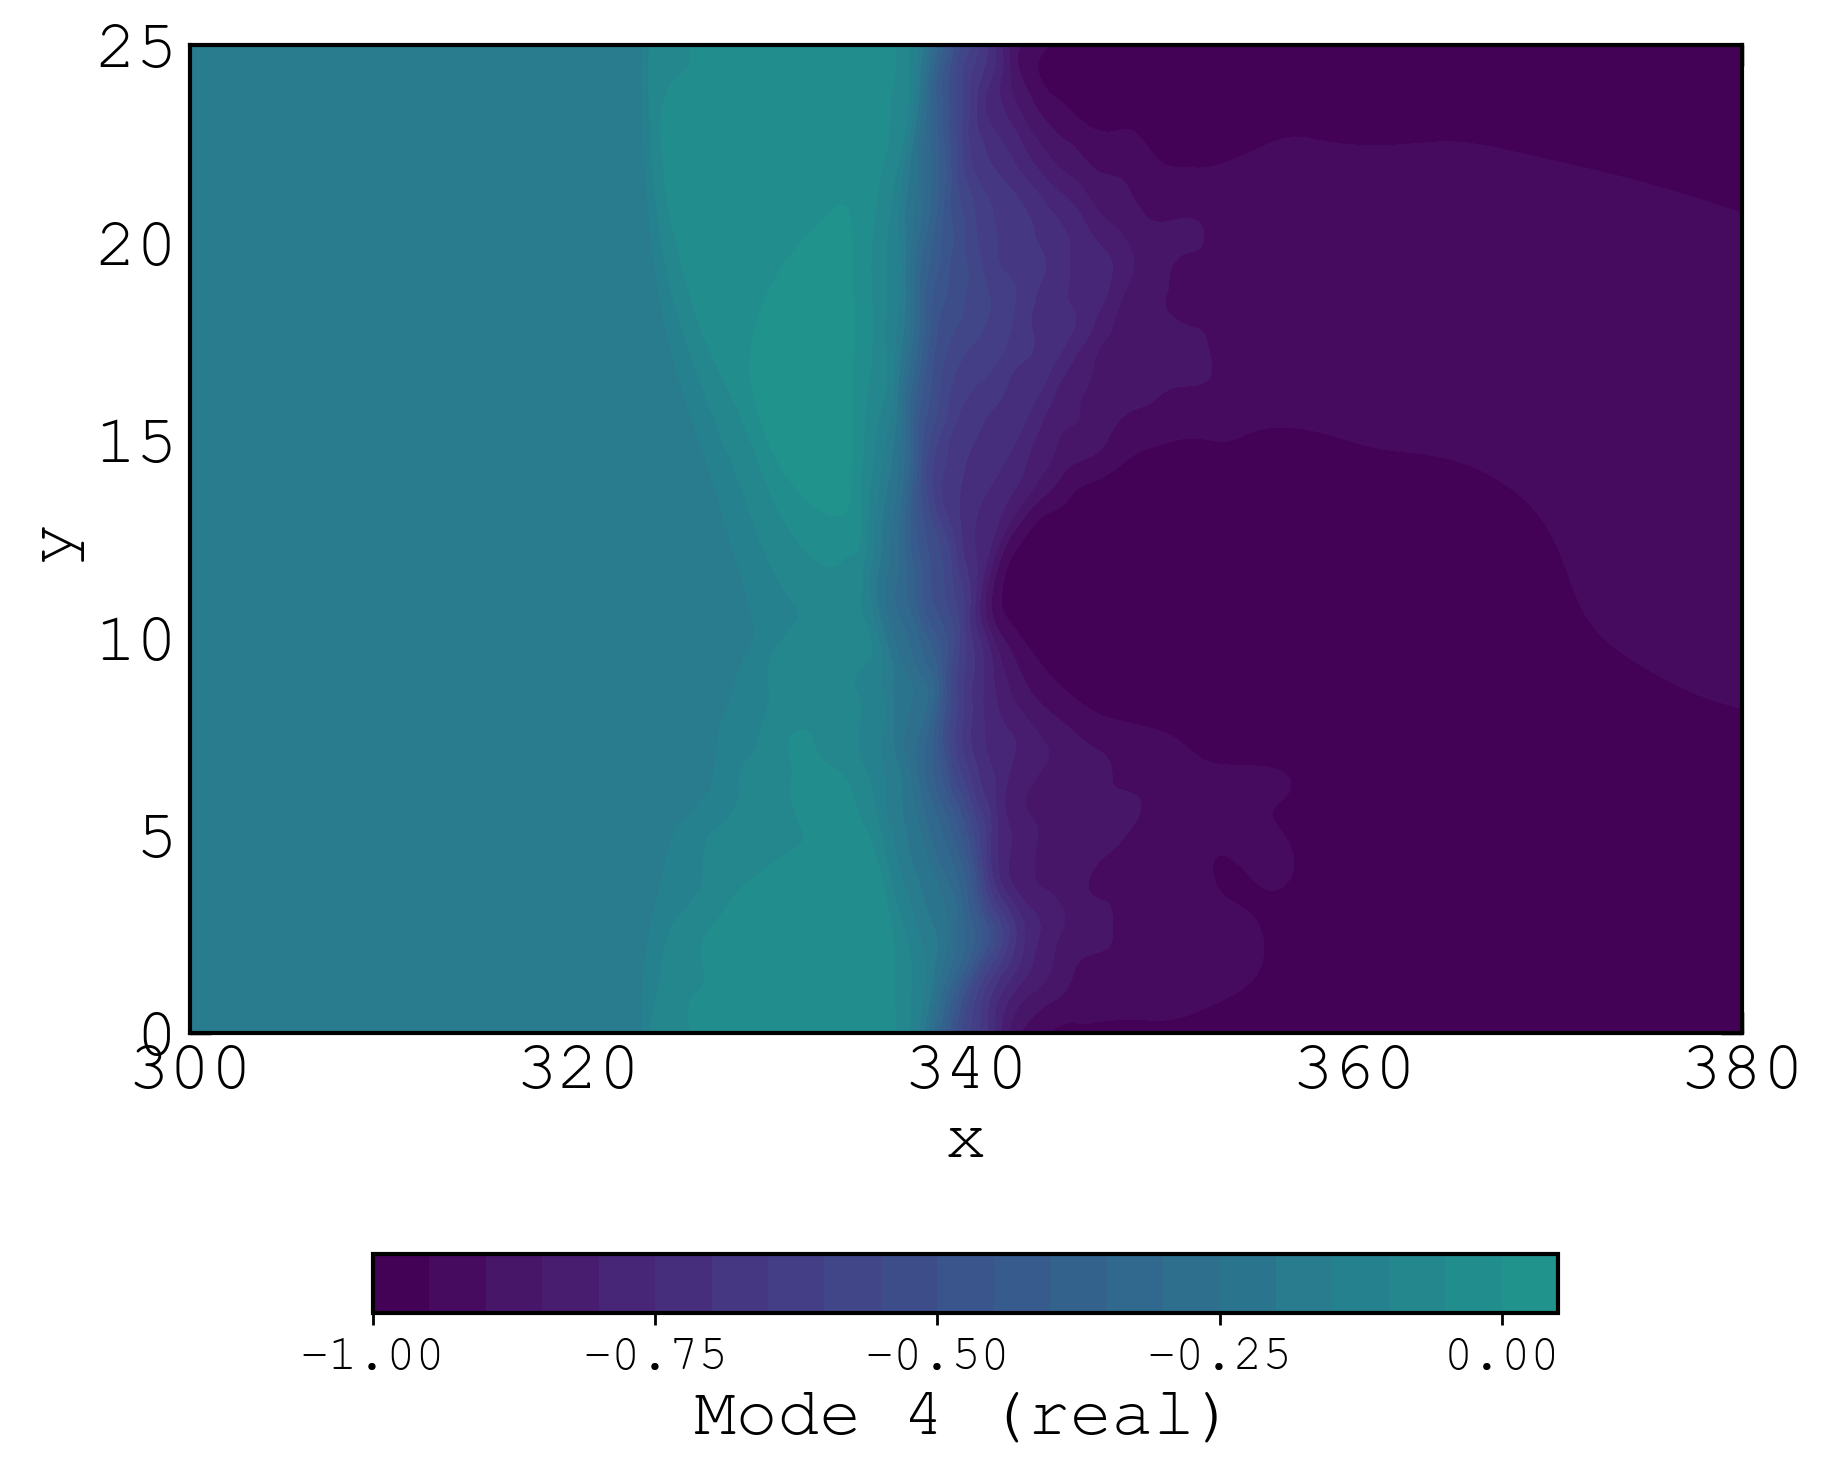

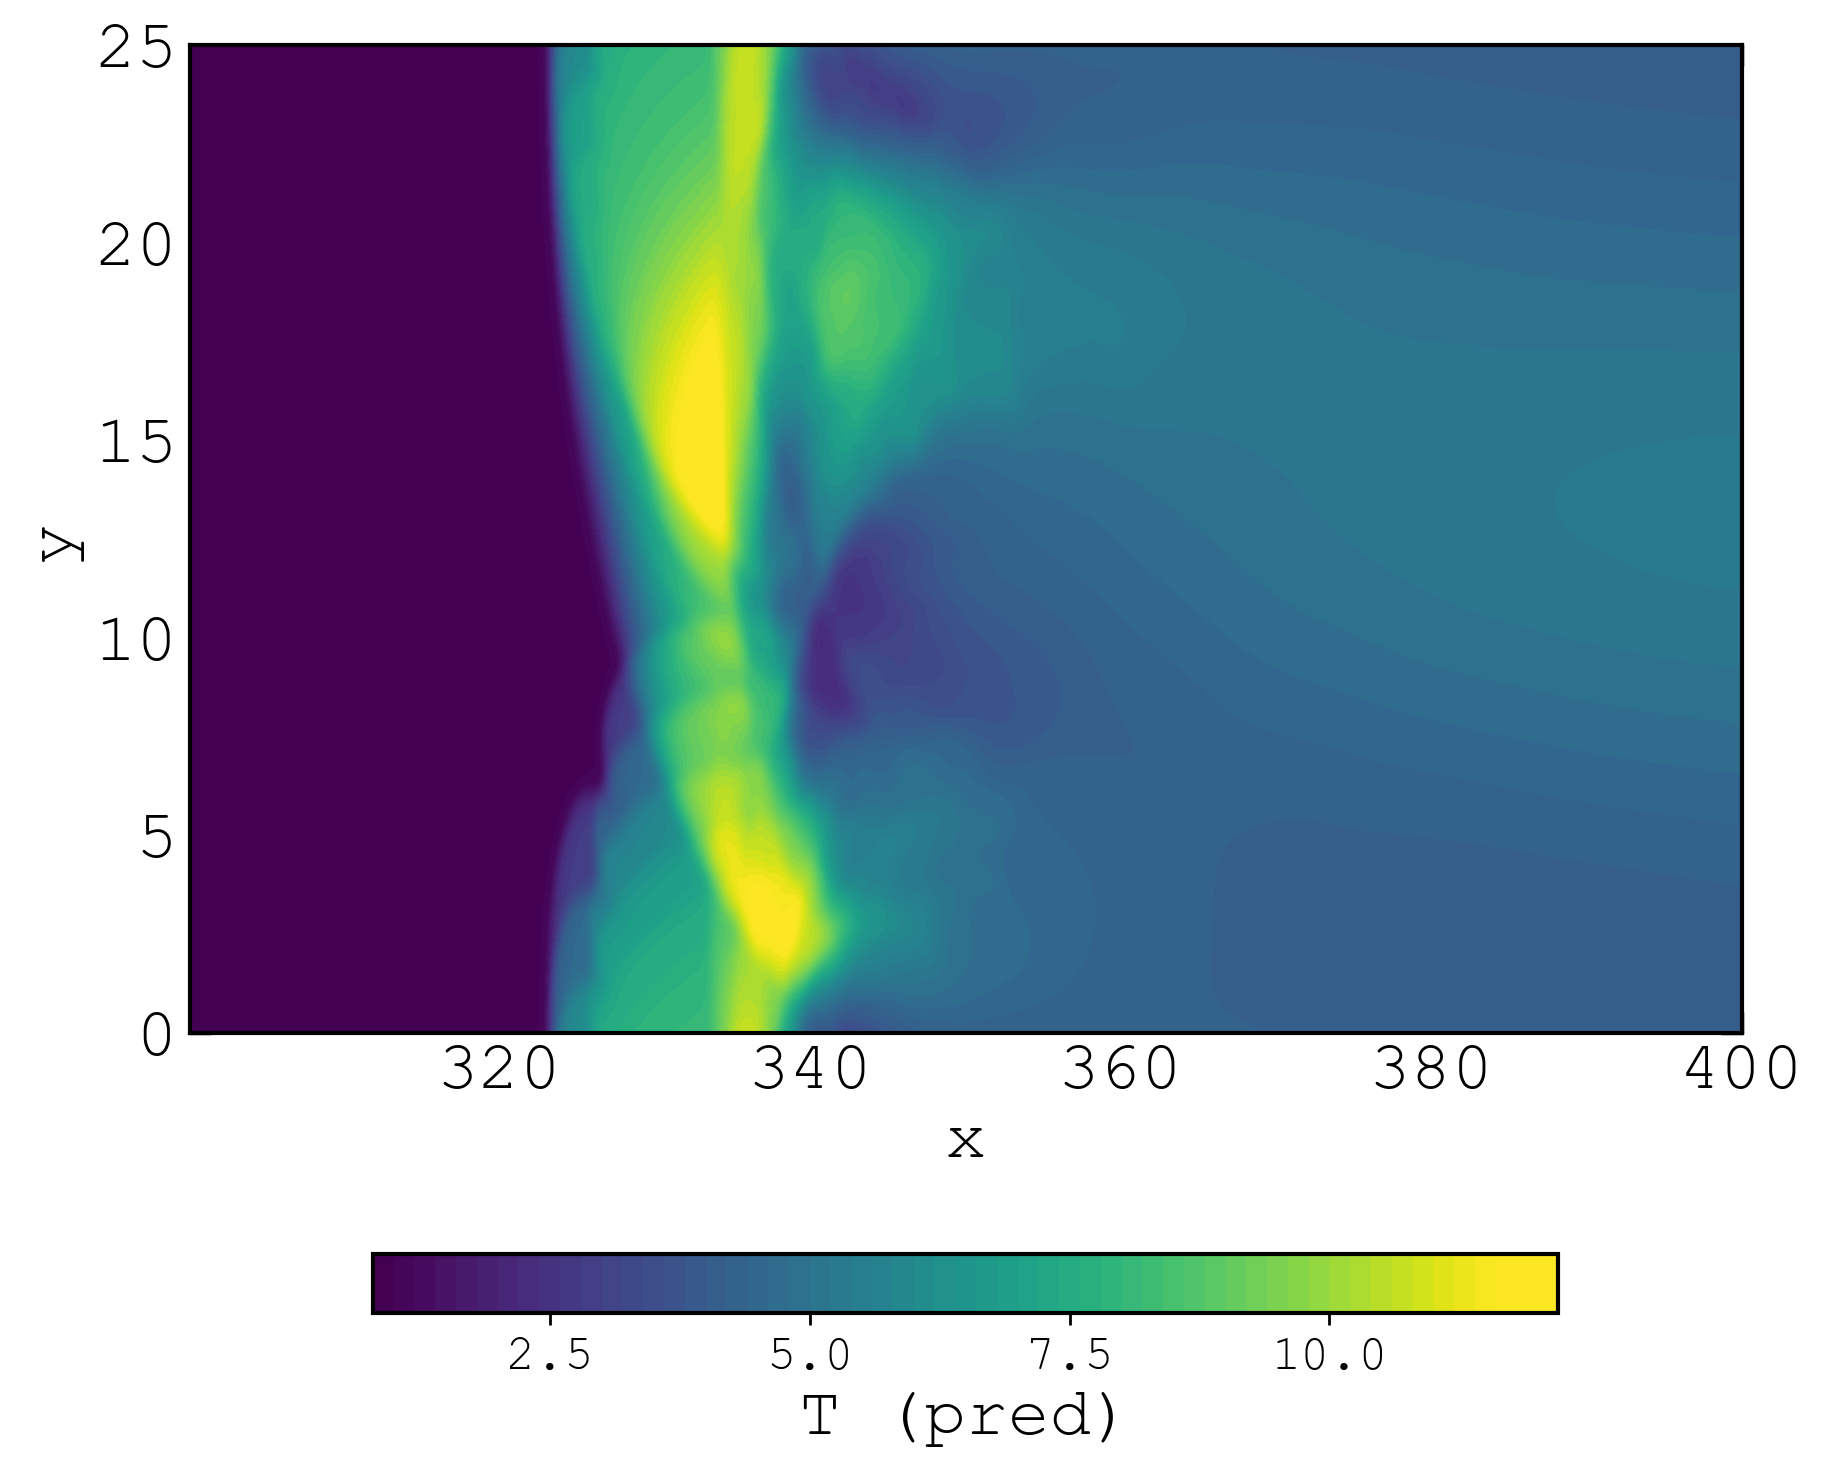

Next-step RMSE: 1.827383e+00
Next-step relative L2 error: 4.434511e-01
Wrote: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/isocontours/phi0.40/h400x025_ref/dmd_err_T_301_xgt300.csv


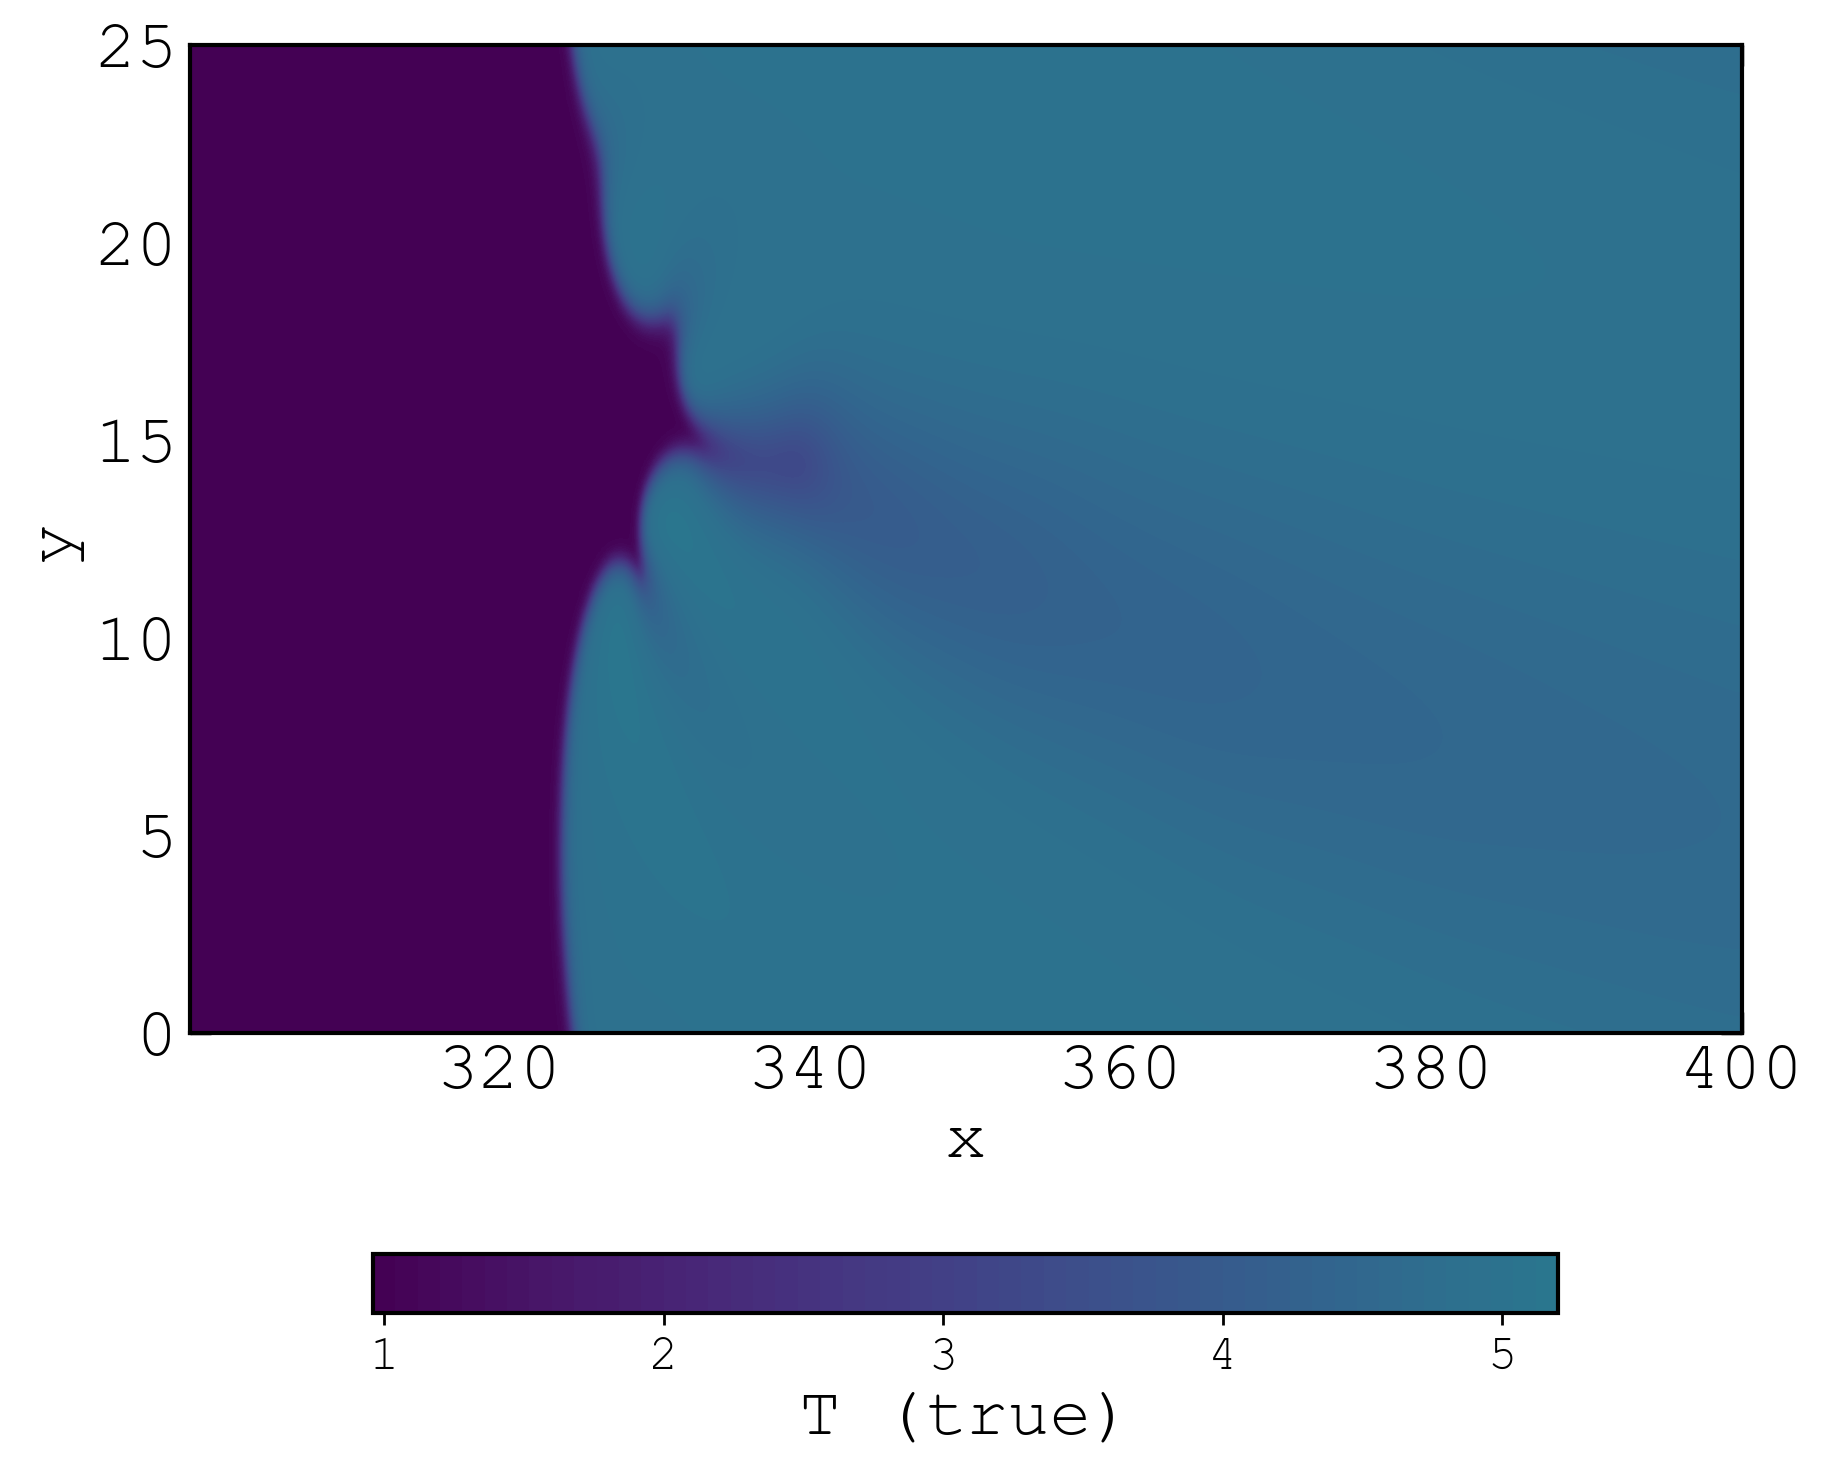

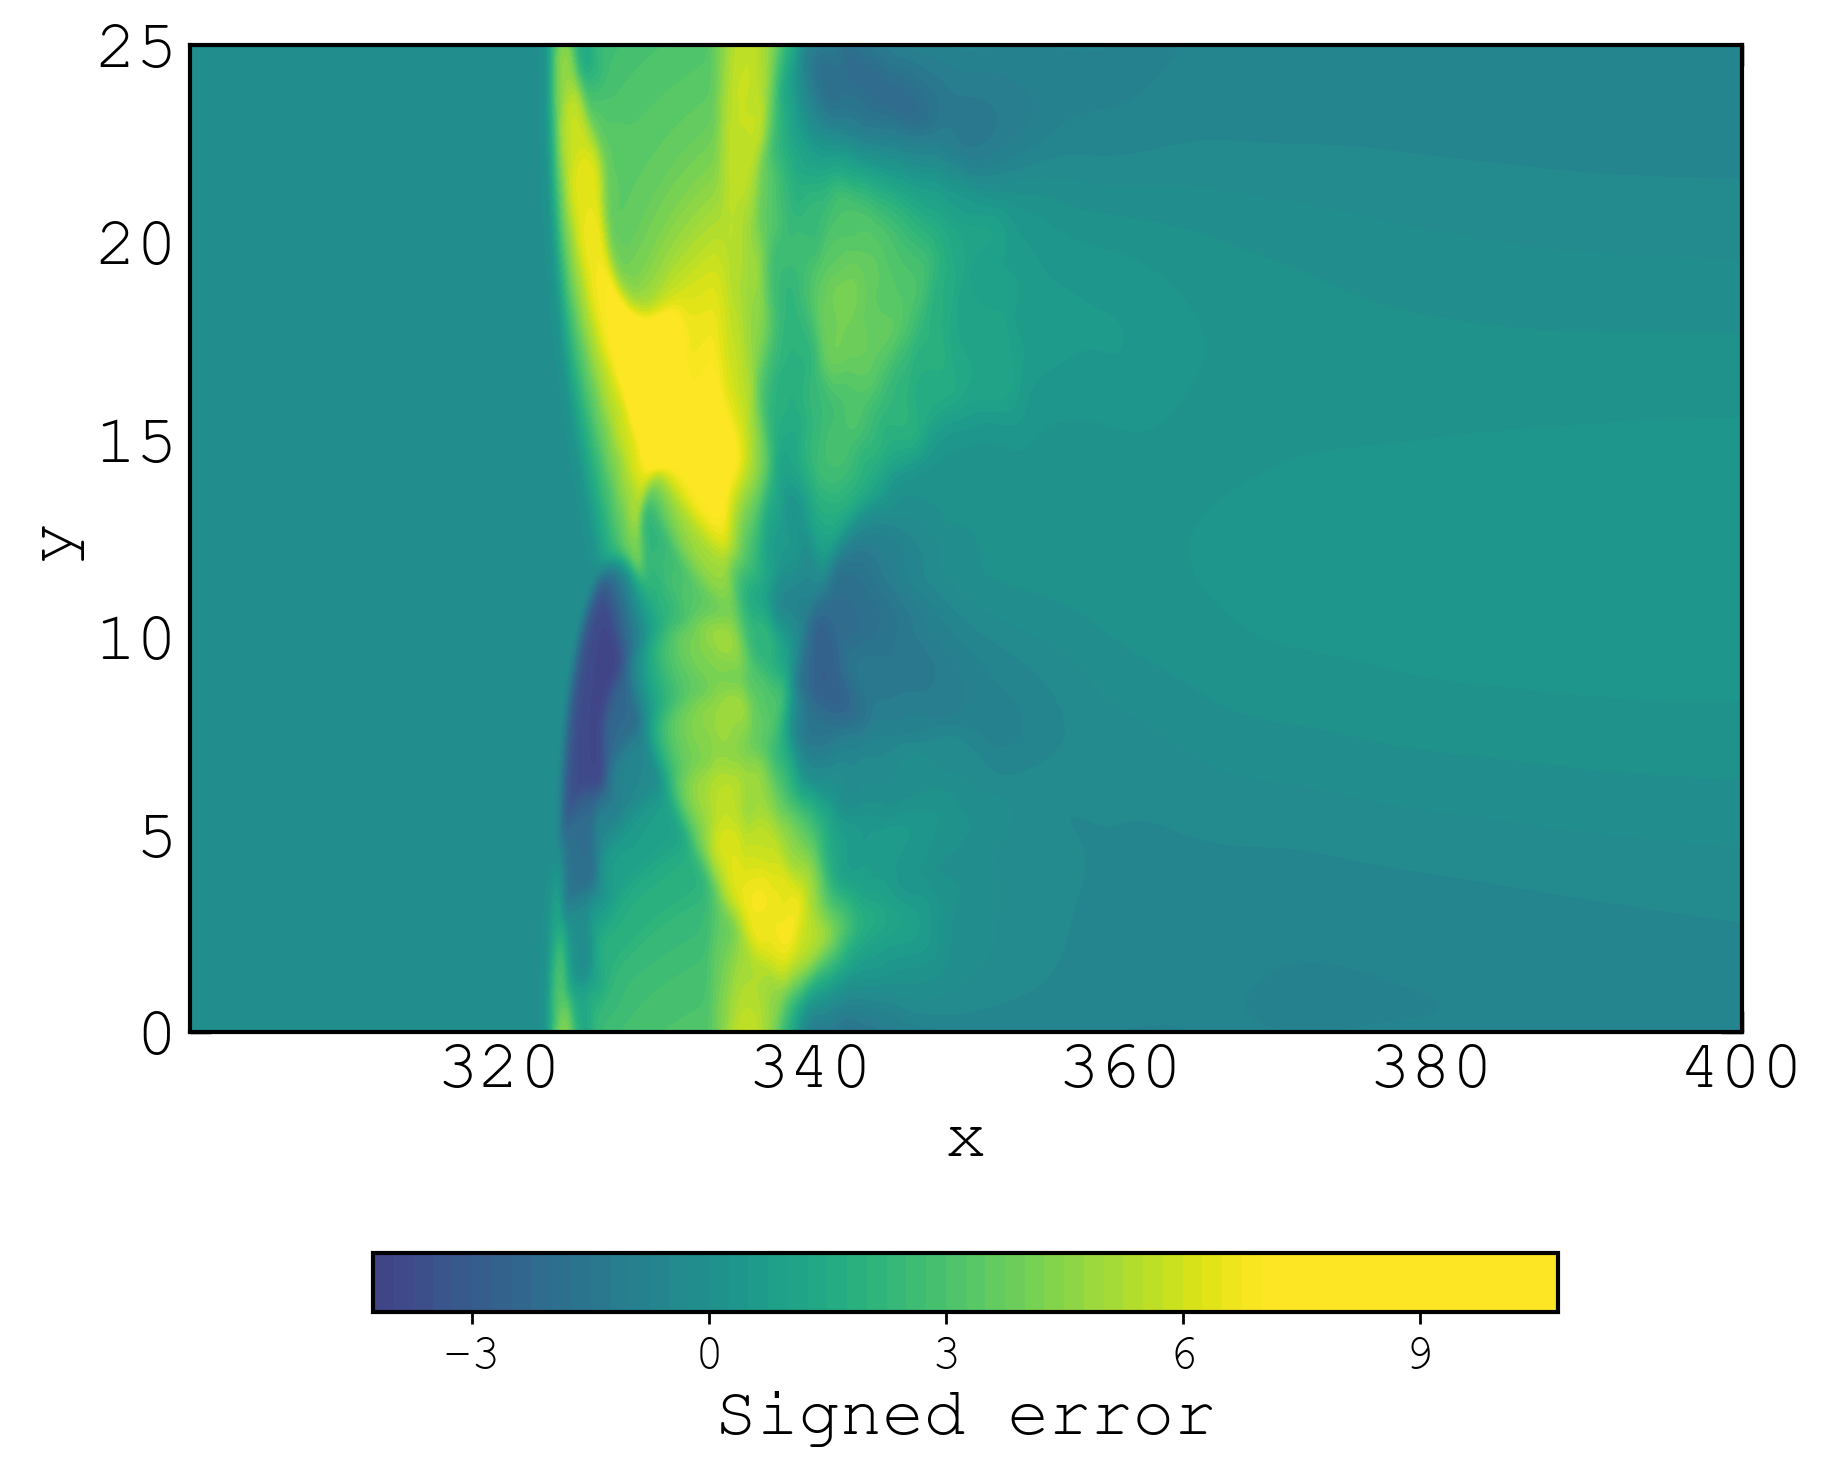

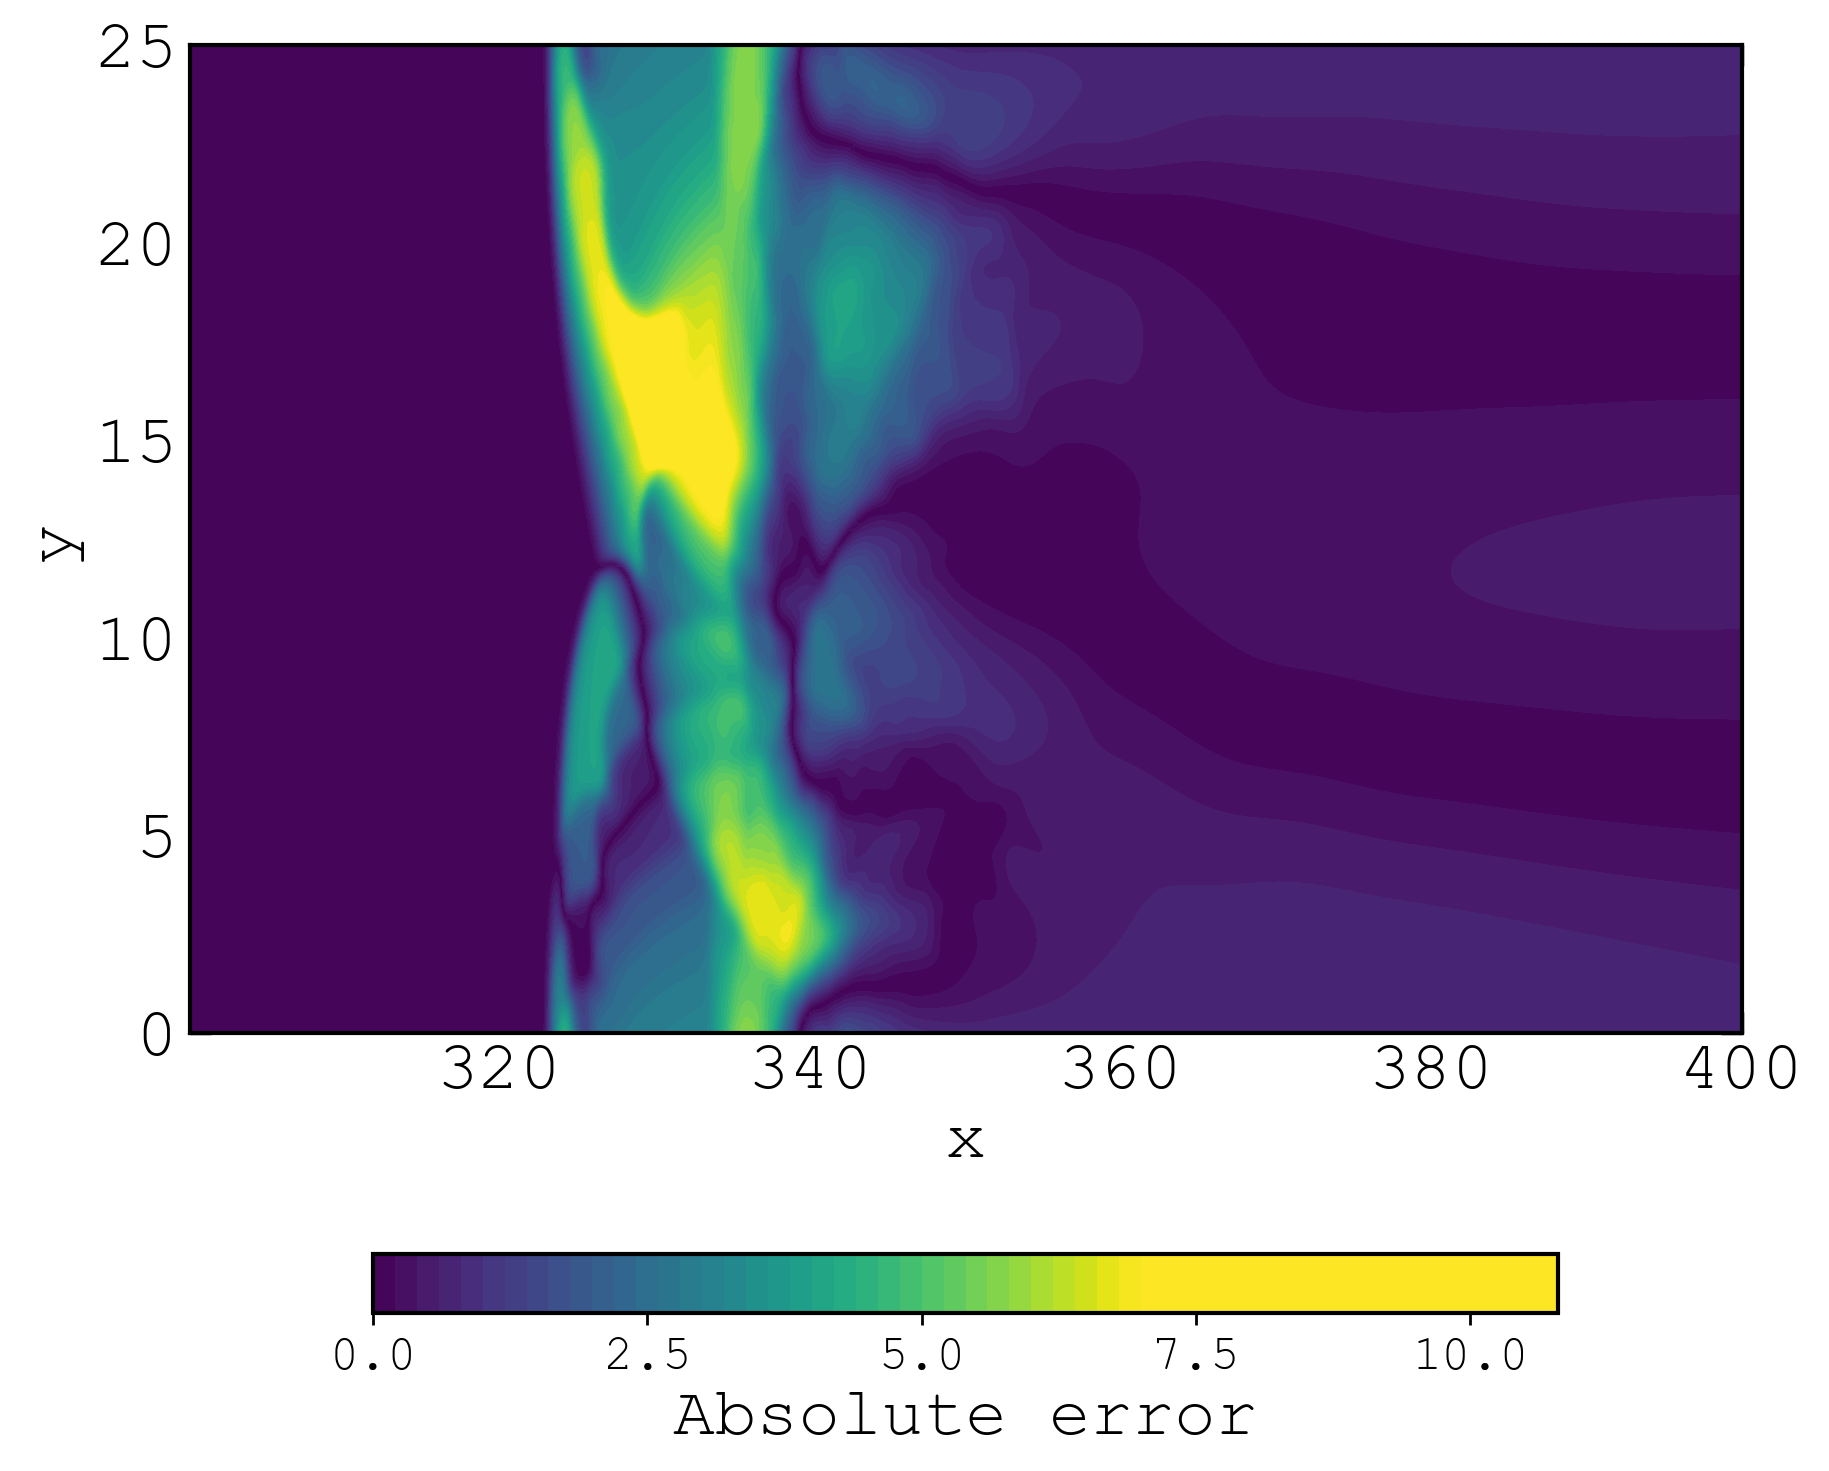

In [26]:
from flamekit.io_fields import field_path
from flamekit.io_fronts import Case

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# ------------------------------------------------------------
# 1) Forecast next snapshot with consistent index-time
# ------------------------------------------------------------
n_train = X.shape[1]


dmd.original_time["t0"]   = 0
dmd.original_time["tend"] = n_train - 1
dmd.original_time["dt"]   = 1.0

dmd.dmd_time["t0"]   = 0
dmd.dmd_time["tend"] = n_train          # +1 step forecast
dmd.dmd_time["dt"]   = 1.0

X_rec = dmd.reconstructed_data          # shape: (n_points_cropped, n_train+1)
x_next_pred = np.asarray(X_rec[:, -1]).real

# Optional diagnostic: eigenvalue stability
lam = np.asarray(dmd.eigs, dtype=complex)
print("Unstable modes (|λ|>1):", int(np.sum(np.abs(lam) > 1.0)))
print("Max |λ|:", float(np.max(np.abs(lam))))

# ------------------------------------------------------------
# 2) Save prediction alongside coordinates (CROPPED)
# ------------------------------------------------------------
t_next = TIME_STEP_END + 1  # keep consistent everywhere

out = pd.DataFrame(coords_ref, columns=SORT_COLS)
out[f"{VAR_NAME}_pred"] = x_next_pred

out_dir = field_path(Case(base_dir=BASE_DIR, phi=PHI, lat_size=LAT_SIZE, time_step=0, post=POST)).parent
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / f"dmd_pred_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}.csv"
out.to_csv(out_path, index=False)
print("Wrote:", out_path)

plot_dir = OUT_DIR
plot_dir.mkdir(parents=True, exist_ok=True)

def save_plot(fig, stem):
    fig.savefig(plot_dir / f"{stem}.png", dpi=FIG_DPI)
    fig.savefig(plot_dir / f"{stem}.pdf")
    fig.savefig(plot_dir / f"{stem}.svg")

# ------------------------------------------------------------
# 3) Build triangulation ONCE for CROPPED coords (for all XY maps)
# ------------------------------------------------------------
x = coords_ref[:, 0].astype(float)
y = coords_ref[:, 1].astype(float)
tri = mtri.Triangulation(x, y)

# Optional: mask skinny triangles (helps avoid artifacts)
try:
    analyzer = mtri.TriAnalyzer(tri)
    mask = analyzer.get_flat_tri_mask(min_circle_ratio=0.02)
    tri.set_mask(mask)
except Exception:
    pass

# ------------------------------------------------------------
# 3A) Plot first 4 modes (one figure per mode)
# ------------------------------------------------------------
modes = np.asarray(dmd.modes)
num_modes = modes.shape[1]
num_plot = min(4, num_modes)

for mode_idx in range(num_plot):
    mode = modes[:, mode_idx]
    mode_real = np.real(mode)
    if NORMALIZE_MODE_FOR_PLOT:
        mode_plot = mode_real / (np.max(np.abs(mode_real)) + 1e-30)
    else:
        mode_plot = mode_real

    vmax_mode = np.percentile(np.abs(mode_plot), 99.0) + 1e-30

    fig = plt.figure(figsize=(7.2, 5.8), dpi=FIG_DPI, constrained_layout=True)
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, mode_plot, levels=MODE_CONTOUR_LEVELS_FILLED, vmin=-vmax_mode, vmax=vmax_mode)
    style_axes(ax)
    ax.set_xlabel(COORD_X)
    ax.set_ylabel(COORD_Y)
    if XLIM is not None:
        ax.set_xlim(XLIM)
    if YLIM is not None:
        ax.set_ylim(YLIM)
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label(f"Mode {mode_idx + 1} (real)")
    style_colorbar(cbar)
    save_plot(fig, f"dmd_mode_{VAR_NAME}_idx{mode_idx + 1:02d}")
    plt.show()

# 3A) Plot PREDICTED field at next timestep (always available)
# ------------------------------------------------------------
vmax_pred = np.percentile(np.abs(x_next_pred), 99.5) + 1e-30
vmin_pred = np.percentile(x_next_pred, 0.5)
vmax_pred_lin = np.percentile(x_next_pred, 99.5)

fig = plt.figure(figsize=(7.2, 5.8), dpi=FIG_DPI, constrained_layout=True)
ax = fig.add_subplot(111)
cf = ax.tricontourf(tri, x_next_pred, levels=60, vmin=vmin_pred, vmax=vmax_pred_lin)
style_axes(ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
cbar.set_label(f"{VAR_NAME} (pred)")
style_colorbar(cbar)
save_plot(fig, f"dmd_pred_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}")
plt.show()

# ------------------------------------------------------------
# 3B) Compare to true next snapshot + error metrics + plots
# ------------------------------------------------------------
path_true = field_csv_path(BASE_DIR, PHI, LAT_SIZE, t_next, POST)

if path_true.exists():
    # Read TRUE snapshot FULL first
    coords_true_full, snap_true_full = read_field_sorted(path_true, VAR_NAME, SORT_COLS)

    # Coordinate check on FULL coords (prevents false mismatch due to masking)
    if coords_true_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"True next-step has different full point count: {coords_true_full.shape[0]} vs {coords_ref_full.shape[0]}"
        )

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_true_full, coords_ref_full)
    else:
        same = np.allclose(coords_true_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            "Full coordinates changed; cannot compare directly. "
            "Sorting / interpolation mismatch or mesh changed."
        )

    # Apply SAME mask as training data
    snap_true = snap_true_full[mask_x]

    if snap_true.shape[0] != coords_ref.shape[0] or snap_true.shape[0] != x_next_pred.shape[0]:
        raise RuntimeError("Cropped true snapshot size does not match prediction size. Check mask_x usage.")

    err = x_next_pred - snap_true
    abs_err = np.abs(err)

    rmse = float(np.sqrt(np.mean(err**2)))
    rel_l2 = float(np.linalg.norm(err) / (np.linalg.norm(snap_true) + 1e-30))
    print(f"Next-step RMSE: {rmse:.6e}")
    print(f"Next-step relative L2 error: {rel_l2:.6e}")

    # Save error CSV for later inspection (CROPPED)
    out_err = pd.DataFrame(coords_ref, columns=SORT_COLS)
    out_err[f"{VAR_NAME}_true"] = snap_true
    out_err[f"{VAR_NAME}_pred"] = x_next_pred
    out_err["err"] = err
    out_err["abs_err"] = abs_err
    err_path = out_dir / f"dmd_err_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}.csv"
    out_err.to_csv(err_path, index=False)
    print("Wrote:", err_path)

    # --------------------------------------------------------
    # NEW: Plot TRUE field at next timestep, using SAME color scale as PRED
    # --------------------------------------------------------
    vmin = float(min(np.percentile(snap_true, 0.5), np.percentile(x_next_pred, 0.5)))
    vmax = float(max(np.percentile(snap_true, 99.5), np.percentile(x_next_pred, 99.5)))

    fig = plt.figure(figsize=(7.2, 5.8), dpi=FIG_DPI, constrained_layout=True)
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, snap_true, levels=60, vmin=vmin, vmax=vmax)
    style_axes(ax)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    style_axes(ax)
    style_axes(ax)
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label(f"{VAR_NAME} (true)")
    style_colorbar(cbar)
    save_plot(fig, f"dmd_true_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}")
    plt.show()

    # --------------------------------------------------------
    # 4) XY maps of error (SIGNED + ABSOLUTE)
    # --------------------------------------------------------
    vmax_signed = np.percentile(np.abs(err), 99.0) + 1e-30
    vmax_abs = np.percentile(abs_err, 99.0) + 1e-30

    # Signed error map
    fig = plt.figure(figsize=(7.2, 5.8), dpi=FIG_DPI, constrained_layout=True)
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, err, levels=60, vmin=-vmax_signed, vmax=vmax_signed)
    style_axes(ax)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    style_axes(ax)
    style_axes(ax)
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label("Signed error")
    style_colorbar(cbar)
    save_plot(fig, f"dmd_err_signed_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}")
    plt.show()

    # Absolute error map
    fig = plt.figure(figsize=(7.2, 5.8), dpi=FIG_DPI, constrained_layout=True)
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, abs_err, levels=60, vmin=0.0, vmax=vmax_abs)
    style_axes(ax)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    style_axes(ax)
    style_axes(ax)
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label("Absolute error")
    style_colorbar(cbar)
    save_plot(fig, f"dmd_err_abs_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}")
    plt.show()

else:
    print("True next-step file does not exist, so only the forecast was saved and the predicted field was plotted.")




